# Análise de Churn em empresa de Telecomunicação

A operadora de comunicações Interconnect gostaria de ser capaz de predizer a rotatividade de seus clientes. Se for descoberto que um usuário está planejando trocar de operadora, a empresa oferecerá-lhe códigos promocionais e opções de plano especiais. A equipe de marketing da Interconnect coletou alguns dados pessoais da sua clientela, incluindo a informação sobre seus planos e contratos.

## Plano geral de resolução da tarefa


* **Conhecimento de negócio:** 

    * Nesta etapa procurei saber mais sobre o churn nas empresas de telecomunicação. 


* **Análise exploratória de dados:**

    * Realizar uma análise detalhada dos dados fornecidos, incluindo a compreensão das variáveis, identificação de valores ausentes, tratamento de inconsistências e identificação de padrões e tendências nos dados.

    * Realizar visualizações gráficas e estatísticas descritivas para obter insights sobre os clientes, suas características e comportamentos.

* **Pré-processamento dos dados:**

    * Tratar os valores ausentes, decidindo se é necessário preenchê-los ou removê-los, com base na quantidade de dados faltantes e na relevância das variáveis.

    * Realizar a codificação de variáveis categóricas em formato numérico para que possam ser usadas nos modelos de aprendizado de máquina.

* **Feature engineering:**

    * Realizar transformações nas variáveis existentes, se necessário, para melhorar sua representação e relevância para os modelos.

    * Criar novas variáveis com base no conhecimento do domínio, se aplicável, para fornecer mais informações úteis para a modelagem.

* **Modelagem:**

    * Dividir os dados em conjuntos de treinamento e teste para avaliação dos modelos.

    * Corrigir desbalanço de classes de churn, caso exista. 

    * Selecionar RandomForest, XGBoost, Logistic Regression, CatBoost e DecisionTree como um conjunto de modelos para resolver o problema de classificação de churn.

    * Definir os hiperparâmetros para cada modelo e realizar treinamento usando o conjunto de treinamento.

    * Avaliar a performance de cada modelo usando métricas adequadas e técnicas de validação cruzada para obter estimativas mais robustas.

        * Accuracy (Precisão): É uma métrica simples que mede a taxa de classificações corretas em relação ao total de classificações. É adequada quando as classes estão bem balanceadas no conjunto de dados.

        * F1-Score: É uma métrica que considera tanto a precisão quanto a especificidade. É útil quando há um desequilíbrio entre as classes de churn e não-churn. O F1-Score fornece uma medida balanceada entre a precisão e a capacidade do modelo de identificar corretamente os casos positivos.

        * AUC-ROC: É uma métrica que avalia a capacidade do modelo de distinguir entre as classes positivas e negativas. É especialmente útil quando há um desequilíbrio entre as classes e quando é necessário ter um baixo número de falsos positivos ou falsos negativos.

* **Escolha do melhor modelo:**

    * Comparar as métricas de avaliação dos modelos e selecionar o modelo que apresentar o melhor desempenho geral.

    * Levar em consideração o equilíbrio entre precisão e recall (F1-Score) e a capacidade do modelo de distinguir entre as classes positivas e negativas (AUC-ROC).

* **Análise dos resultados e interpretação:**

    * Realizar uma análise dos resultados obtidos, considerando as características dos clientes, clusters identificados, padrões de churn.

    * Extrair insights possam ser aplicados na tomada de decisões estratégicas para reduzir o churn, melhorar a satisfação do cliente e otimizar as estratégias de marketing.






## Entendo o problema

### Import das bibliotecas necessárias

In [102]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as date

import scipy.stats as st

import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


import xgboost as xgb

import shap
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline 

from tqdm import tqdm


In [106]:
# Estilo dos gráficos
sns.set_style('whitegrid', rc={'grid.linestyle': ':'})
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Leitura dos arquivos .csv

In [107]:
data_contract = pd.read_csv('contract.csv')

data_internet = pd.read_csv('internet.csv')

data_personal = pd.read_csv('personal.csv')

data_phone = pd.read_csv('phone.csv')

In [108]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [109]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [110]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [111]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Unindo os dataframes

In [112]:
df_telecom = pd.merge(data_contract, data_personal, on='customerID', how='left')
df_telecom = pd.merge(df_telecom, data_internet, on='customerID', how='left')
df_telecom = pd.merge(df_telecom, data_phone, on='customerID', how='left')

### Primeiras impressões sobre os dados

In [113]:
df_telecom.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [114]:
# Formato do dataframe
print(f'Número de linhas: {df_telecom.shape[0]}')
print(f'Número de colunas: {df_telecom.shape[1]}')

Número de linhas: 7043
Número de colunas: 20


In [115]:
# Tipos de variáveis
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [116]:
print(f'impacto dos valores ausentes no dataframe:\n{df_telecom.isna().mean()*100}')

impacto dos valores ausentes no dataframe:
customerID           0.000000
BeginDate            0.000000
EndDate              0.000000
Type                 0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
InternetService     21.666903
OnlineSecurity      21.666903
OnlineBackup        21.666903
DeviceProtection    21.666903
TechSupport         21.666903
StreamingTV         21.666903
StreamingMovies     21.666903
MultipleLines        9.683374
dtype: float64


In [117]:
#Corrigindo o tipo de variável da coluna 'BeginDate'
df_telecom['BeginDate'] = pd.to_datetime(df_telecom['BeginDate'])
df_telecom['BeginDate'].dtype

dtype('<M8[ns]')

In [118]:
#Corrigindo o tipo de variável da coluna 'TotalCharges'
# A coluna não possui valores ausentes, porém alguns valores continham uma string vazia ' ' (segundo erro no momento de mudar o tipo da variável)
df_telecom['TotalCharges'] = df_telecom['TotalCharges'].replace(' ', np.nan).astype('float')
df_telecom['TotalCharges'].dtype

dtype('float64')

In [119]:
# Separando os tipos de variáveis categóricas para ver as categorias de cada uma
def separate_cat_var (data, col):
    cat_cols = []
    cat_bin = [] #categorias binárias
    cat_num = []

    for col, dtype in data.dtypes.items():
        if dtype.name == 'object':
            if data[col].nunique() > 2 and data[col].nunique() <= 4: 
                cat_cols.append(col)
            elif data[col].nunique(dropna=False) <= 2:
                cat_bin.append(col)
            elif data[col].nunique() <= 2:  
                cat_bin.append(col)
        else:
            cat_num.append(col)
    return cat_cols, cat_bin, cat_num

In [120]:
cat_cols, cat_bin, cat_num = separate_cat_var(df_telecom, df_telecom.columns)

In [121]:
cat_num.pop(3)
cat_bin.append('SeniorCitizen')

In [122]:
print(f'Variáveis categóricas múltiplas: {cat_cols}\n')
print(f'Variáveis categóricas binárias: {cat_bin}\n')
print(f'Variáveis categóricas numéricas: {cat_num}\n')

Variáveis categóricas múltiplas: ['Type', 'PaymentMethod']

Variáveis categóricas binárias: ['PaperlessBilling', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'SeniorCitizen']

Variáveis categóricas numéricas: ['BeginDate', 'MonthlyCharges', 'TotalCharges']



In [123]:
for col in cat_cols:
    value_counts = df_telecom[col].value_counts()
    print(f'categorias na coluna {col}:\n{value_counts}\n')

categorias na coluna Type:
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

categorias na coluna PaymentMethod:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64



In [124]:
for col in cat_bin:
    value_counts = df_telecom[col].value_counts()
    print(f'categorias na coluna {col}:\n{value_counts}\n')

categorias na coluna PaperlessBilling:
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

categorias na coluna gender:
Male      3555
Female    3488
Name: gender, dtype: int64

categorias na coluna Partner:
No     3641
Yes    3402
Name: Partner, dtype: int64

categorias na coluna Dependents:
No     4933
Yes    2110
Name: Dependents, dtype: int64

categorias na coluna InternetService:
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

categorias na coluna OnlineSecurity:
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

categorias na coluna OnlineBackup:
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

categorias na coluna DeviceProtection:
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

categorias na coluna TechSupport:
No     3473
Yes    2044
Name: TechSupport, dtype: int64

categorias na coluna StreamingTV:
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

categorias na coluna StreamingMovies:
No     2785
Ye

In [125]:
df_telecom.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


In [126]:
df_telecom['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

* O dataframe possui 7043 observações com 13 variáveis incluindo a variável que armazena o target (não-churn).

* Valores ausentes correspondem a clientes que não contrataram serviços de internet e múltiplas linhas na telefonia fixa.
    * Há valores ausentes nos dados. As colunas que armazenam os tipos de serviços de internet ('InternetService', 'OnlineSecurity', 'OnlineBackup' 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies') e telefonia fixa com múltiplas linhas ('MultipleLines'). Isso se deve, provavelmente ao merge dos dataframes, onde não foi encontrado o 'customerID' do cliente na tabela à esquerda.
<br></br>
* A coluna TotalCharges possui 11 valores ausentes.

* Com relação as variáveis categoricas temos que:
    * Ambas contem 7043 observaçoes.
    * A Cobrança mensal e o Gasto total são variáveis bastante dispersas com média e medianas distantes e devio padrão alto. Os valores mínimo e máximo mostram como há valores atípicos em ambas as colunas.
<br></br>
* As classe de churn e não-churn estão desbalanceadas.

* Abaixo tem um quadro resumo de cata variável e sua descrição:

| Variável          | Descrição                                           |
|-------------------|-----------------------------------------------------|
| customerID        | Identificador único codificado para cada cliente     |
| BeginDate         | Data de início do contrato                           |
| EndDate           | Se o cliente cancelou ou não o contrato. Dois tipos de observações:<br>'No' - corresponde a clientes que permaneceram com um contrato ativo<br>Data - a data em que o cliente deixou a empresa |
| Type              | Tipo de contrato:<br>Month-to-month - Pagamento mensal<br>One year - Contrato de 1 ano<br>Two year - Contrato de 2 anos |
| PaperlessBilling  | Se o cliente possui fatura sem papel                 |
| PaymentMethod     | Método de pagamento:<br>Electronic check<br>Mailed check<br>Bank transfer (automatic)<br>Credit card (automatic) |
| MonthlyCharges    | Valor da cobrança mensal                            |
| TotalCharges      | Valor total pago pelo serviço                        |
| gender            | Gênero (Feminino ou Masculino)                       |
| SeniorCitizen     | Se o cliente é idoso                                |
| Partner           | Se o cliente possui um parceiro                      |
| Dependents        | Se o cliente possui dependentes                      |
| InternetService   | Tipo de serviço de internet:<br>DSL - Linha de assinante digital<br>Cabo de fibra óptica |
| OnlineSecurity    | Proteção online (software antivírus)                 |
| OnlineBackup      | Armazenamento de arquivos online e backup de dados    |
| DeviceProtection  | Proteção do dispositivo (bloqueador de sites maliciosos) |
| TechSupport       | Suporte técnico dedicado                            |
| StreamingTV       | Streaming de TV                                     |
| StreamingMovies   | Acesso a um diretório de filmes                      |
| MultipleLines     | Se o plano de telefone fixo permite várias linhas ao mesmo tempo |


## Preparação dos Dados

### Criando cópia do dataframe original

In [127]:
telecom_copy = df_telecom.copy()

In [128]:
telecom_copy.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Corrigindo inconsistências nos dados

In [129]:
# Passando a nomeclatura das variáveis para snake_case
def camel_to_snake(column_name):
    # A coluna já está no formato desejado?
    if re.search(r'^[a-z][a-zA-Z0-9]*$', column_name):
        return column_name
    
    # Usando regex para localizar todas as letras maiúsculas seguidas por zero ou mais letras minúsculas ou dígitos
    words = re.findall('[A-Z][a-z0-9]*', column_name)
    
    snake_case = '_'.join([word.lower() for word in words])
    
    return snake_case

In [130]:
telecom_copy.columns = [camel_to_snake(col) for col in telecom_copy.columns]
telecom_copy.columns

Index(['customerID', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [131]:
telecom_copy.rename(columns={'customerID' : 'customer_id'}, inplace=True)
telecom_copy.rename(columns={'streaming_t_v' : 'streaming_tv'}, inplace=True)
telecom_copy.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [132]:
# Preenchendo os valores ausentes das colunas de serviço de internet com 'não contratado'
telecom_copy['internet_service'].fillna('not contracted', inplace=True)
# Verificando resultado
telecom_copy['internet_service'].isna().sum()

0

In [133]:
# Preenchendo os valores ausentes das colunas de múltiplas linhas com 'não contratado'
telecom_copy['multiple_lines'].fillna('not contracted', inplace=True)
# Verificando resultado
telecom_copy['multiple_lines'].isna().sum()

0

In [134]:
# Preenchendo as colunas com serviços de internet com 'não se aplica', uma vez que o serviço de internet não foi contratado
cols_to_fill = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for col in cols_to_fill:
    telecom_copy[col].fillna('not apply', inplace=True)
telecom_copy[cols_to_fill].isna().sum()

online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [135]:
filtro = telecom_copy[telecom_copy['end_date'] != 'No']

In [136]:
telecom_copy['end_date'] = pd.to_datetime(filtro['end_date'])

In [137]:
telecom_copy['contract_time'] = (telecom_copy['end_date'] - telecom_copy['begin_date']).dt.days / 30

In [138]:
telecom_copy['contract_time'].head()

0         NaN
1         NaN
2    2.033333
3         NaN
4    2.033333
Name: contract_time, dtype: float64

In [139]:
total_charges_nan = telecom_copy[telecom_copy['total_charges'].isna() == True]
total_charges_nan.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_time
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,not contracted,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,not contracted,not apply,not apply,not apply,not apply,not apply,not apply,No,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,not contracted,not apply,not apply,not apply,not apply,not apply,not apply,Yes,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,not contracted,NaN


In [140]:
telecom_copy[['begin_date', 'end_date']].max()

begin_date   2020-02-01
end_date     2020-01-01
dtype: datetime64[ns]

In [141]:
data_maxima= telecom_copy['begin_date'].max()
telecom_copy['contract_time'] = telecom_copy['contract_time'].fillna((data_maxima - telecom_copy['begin_date']).dt.days / 30)

In [142]:
telecom_copy['contract_time'].isna().sum()

0

In [143]:
telecom_copy['total_charges'] = telecom_copy['total_charges'].fillna(telecom_copy['contract_time']*telecom_copy['monthly_charges'])

In [144]:
telecom_copy['total_charges'].isna().sum()

0

In [145]:
#Criando nova coluna que armazena a classificação de churn 
telecom_copy['end_date_class'] = telecom_copy['end_date'].apply(lambda x: '1' if '20' in str(x) else '0').astype('int')

In [146]:
cat_cols, cat_bin, cat_num = separate_cat_var(telecom_copy, telecom_copy.columns)

In [147]:
cat_num

['begin_date',
 'end_date',
 'monthly_charges',
 'total_charges',
 'senior_citizen',
 'contract_time',
 'end_date_class']

In [148]:
cat_num.pop(1)
cat_num.pop(3)
cat_num.pop(4)

cat_bin.append('senior_citizen')

In [149]:
print(f'Variáveis categóricas múltiplas: {cat_cols}\n')
print(f'Variáveis categóricas binárias: {cat_bin}\n')
print(f'Variáveis numéricas: {cat_num}')

Variáveis categóricas múltiplas: ['type', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

Variáveis categóricas binárias: ['paperless_billing', 'gender', 'partner', 'dependents', 'senior_citizen']

Variáveis numéricas: ['begin_date', 'monthly_charges', 'total_charges', 'contract_time']


## Análise Exploratória dos Dados

### Explorando a variável target ('end_date')

In [150]:
telecom_copy.end_date_class.value_counts()

0    5174
1    1869
Name: end_date_class, dtype: int64

In [151]:
proportions = telecom_copy['end_date_class'].value_counts(normalize=True)
print(f'Proporção entre classes:\n{np.round(proportions*100)}')

class_imbalance_ratio = np.sum(telecom_copy['end_date_class'] == 1) / np.sum(telecom_copy['end_date_class'] == 0)
print(f'Índice de desequilíbrio de classes: {class_imbalance_ratio:.2f}')

Proporção entre classes:
0    73.0
1    27.0
Name: end_date_class, dtype: float64
Índice de desequilíbrio de classes: 0.36


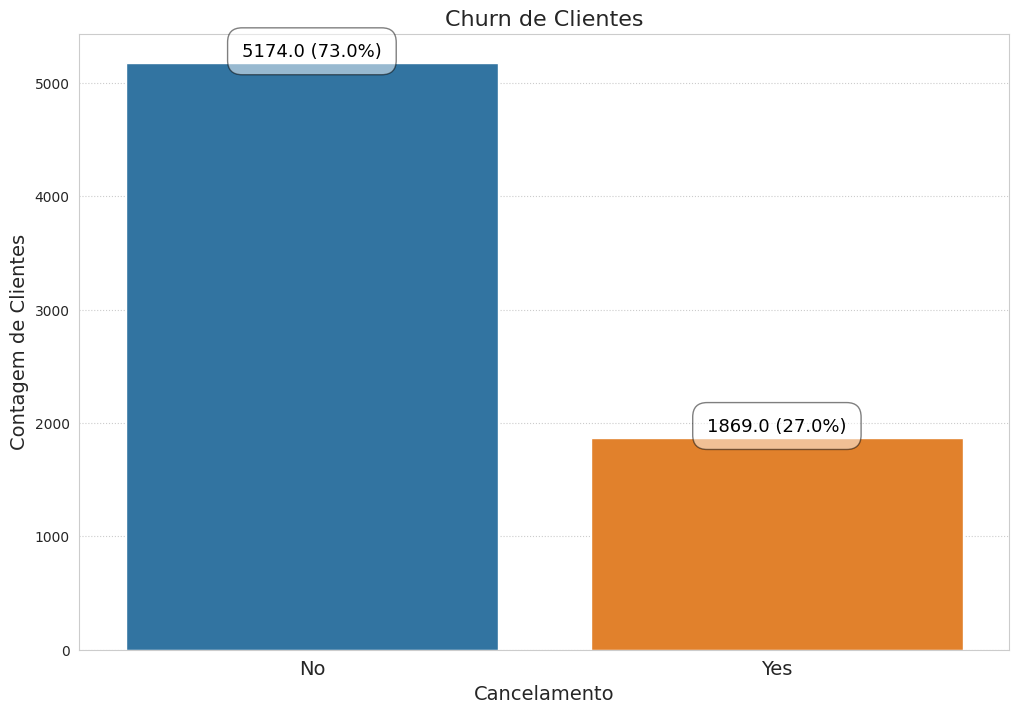

In [152]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(data=telecom_copy, x='end_date_class', ax=ax)
plt.title('Churn de Clientes', fontsize=16)
plt.xlabel('Cancelamento', fontsize=14)
plt.ylabel('Contagem de Clientes', fontsize=14)
ax.set_xticklabels(['No', 'Yes'], fontsize=14)

churn_percentage  = telecom_copy['end_date_class'].value_counts(normalize=True)
churn_percentage = np.round(churn_percentage*100)
churn_percentage

for p, percentage in zip(ax.patches, churn_percentage):
    height = p.get_height()
    height = p.get_height()
    if height > 0:  # Exclude bars with height 0
        ax.annotate(f'{height} ({percentage}%)',
                    xytext=(0, 2),
                    textcoords='offset points',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=13,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8', alpha=0.5))


plt.show()


Há uma proporção significativamente menor do grupo não churn. As classes são, portanto, desequilibradas.

### Explorando variáveis por classe de churn

In [153]:
telecom_copy[cat_num].describe()

,monthly_charges,total_charges,contract_time
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,32.866539
std,30.090047,2266.794470,24.919595
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,9.100000
50%,70.350000,1394.550000,29.433333
75%,89.850000,3786.600000,55.866667
max,118.750000,8684.800000,73.033333


In [154]:
cols = cat_cols + cat_bin
cols.pop(-1)

'senior_citizen'

In [155]:
telecom_copy[cols].describe()

,type,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,paperless_billing,gender,partner,dependents
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,3,4,3,3,3,3,3,3,3,3,2,2,2,2
top,Month-to-month,Electronic check,Fiber optic,No,No,No,No,No,No,No,Yes,Male,No,No
freq,3875,2365,3096,3498,3088,3095,3473,2810,2785,3390,4171,3555,3641,4933


* Todas as variáveis possuem 7043 observações, ou seja, não há campos vazios.

* A Cobrança mensal média é de 64,76 e desvio padrão de 30,09. Os valores mínimos e máximos são 18,25 e 118,75, respectivamente. Os quartis 25% e 75% sugerem uma distribuição concentrada nas faixas de 35,5 a 89,85. 

* O Gasto total médio é de de 2283.30, o desvio padrão é de 2265.00 quase o mesmo valor que a média, ou seja, a há uma grande dispersão nos dados. Os valores mínimo e máximo e mínimo são 18,80 e  8684,80, respectivamente. Os quartis também mostram um intervalo considerável, com valores concentrados nas faixas de 402,225 à 378,60.   

* O tempo de contrato médio é de 32,8 meses. Os intervalos vão de 0 meses a 73 meses.

* A maioria dos clientes é do sexo masculino, não possuem parceiros e nem dependentes. Eles optam por contrato mensal, pagamento por meio de cheque eletronico, fatura sem papel, fibra ótica como internet e não contrataram serviços adicionais de internet.

In [156]:
telecom_copy.skew()

The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


monthly_charges   -0.220524
total_charges      0.963235
senior_citizen     1.833633
contract_time      0.239493
end_date_class     1.063031
dtype: float64

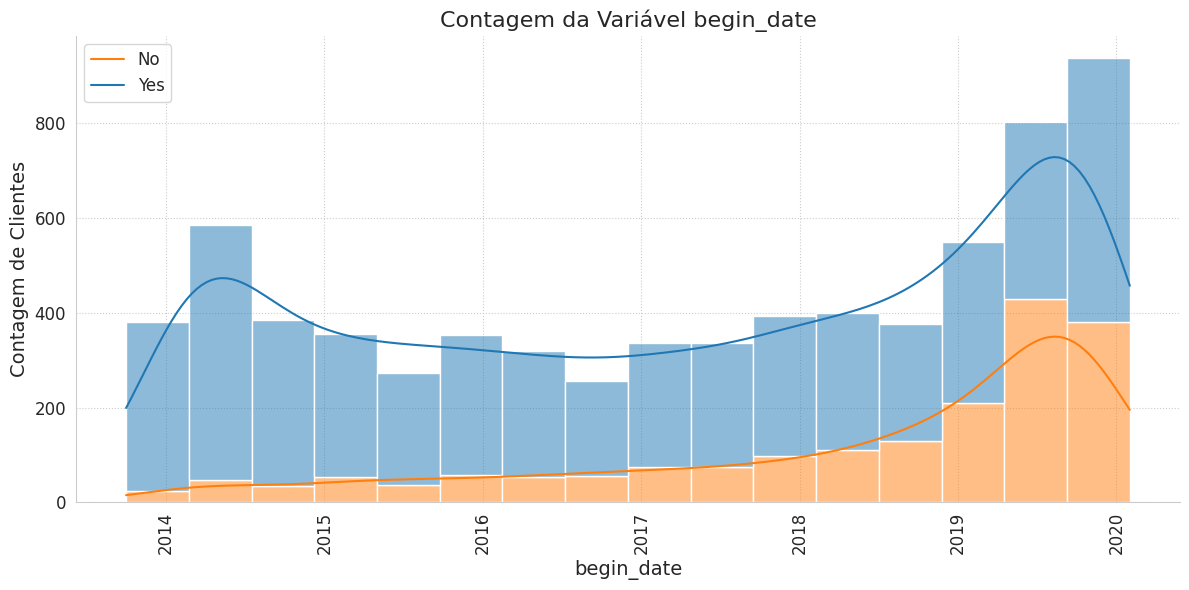

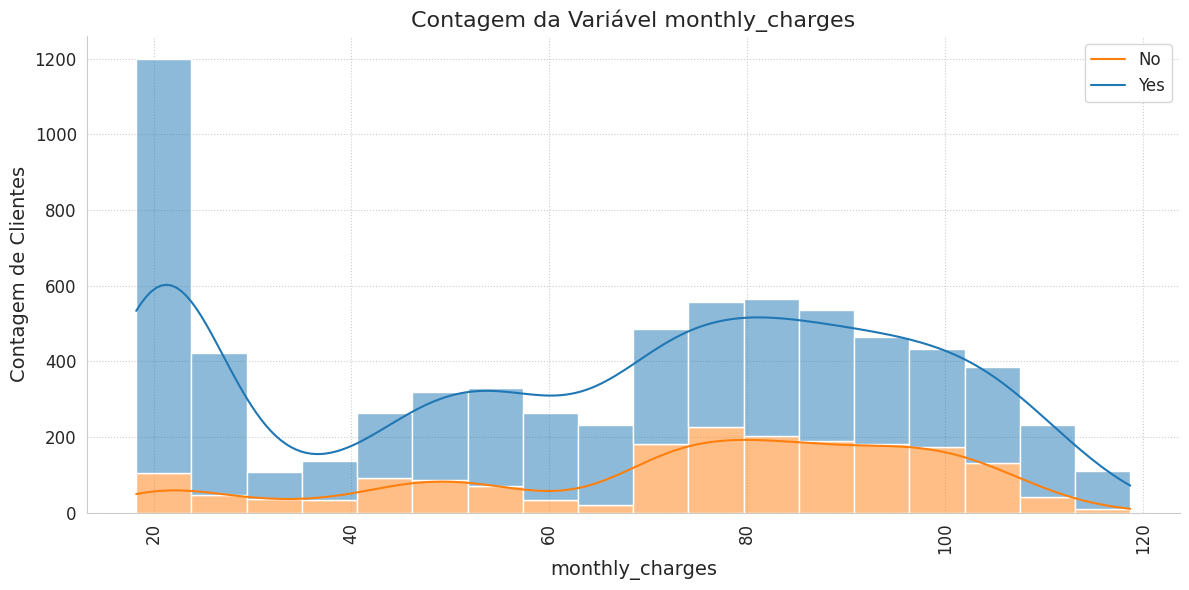

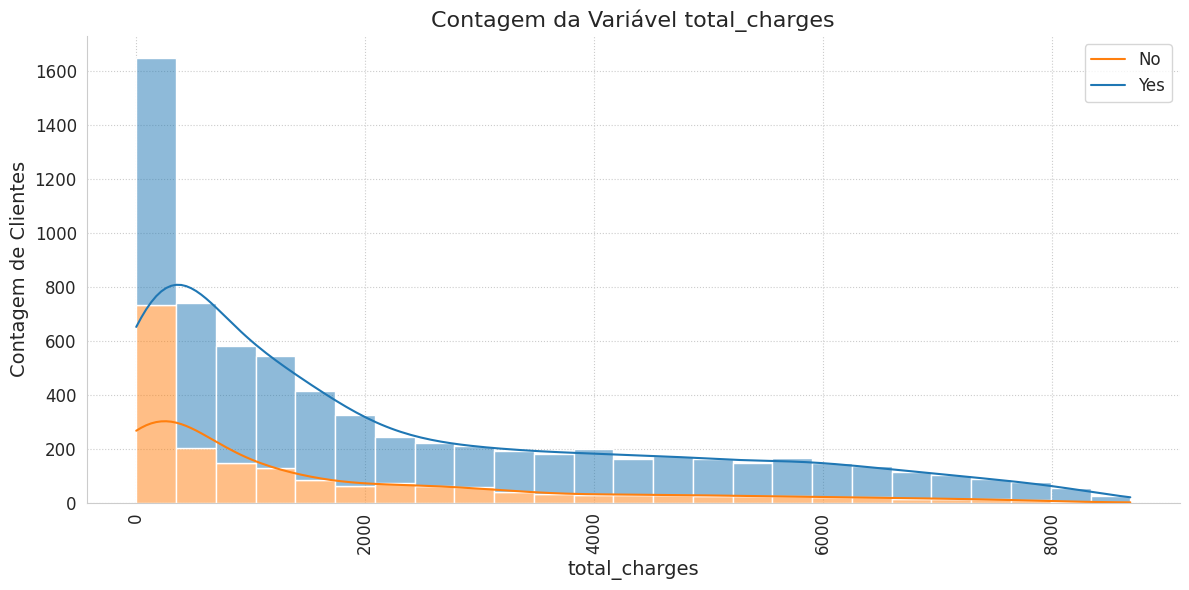

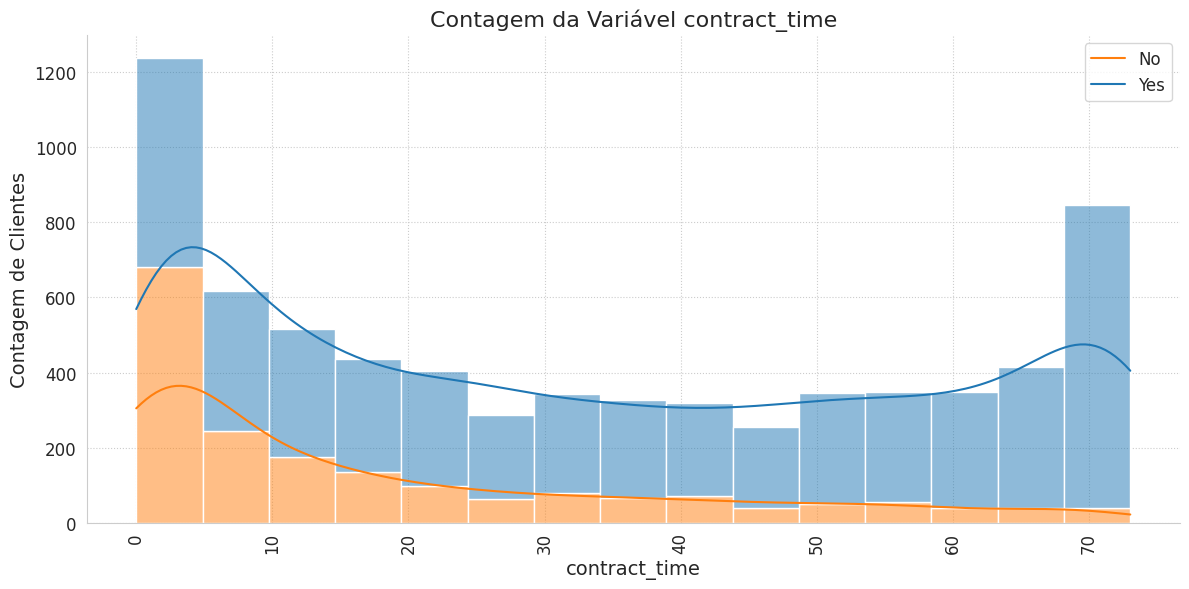

In [157]:
for col in cat_num:
    fig, ax = plt.subplots(figsize=(12,6))
    sns.histplot(data=telecom_copy, x=col, hue='end_date_class', multiple='stack', ax=ax, kde=True)
    ax.set_title("Contagem da Variável " + col, fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('Contagem de Clientes', fontsize=14)
    ax.legend(['No', 'Yes'], fontsize=12)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

* **Clientes não-churn:**

    * Há dois subgrupos de clientes em termos de início de contrato, aqueles com contratos mais antigos (2014-2015) e outros com contratos mais recentes (2019-2020).

    * A variável de cobrança mensal apresenta três modas distintas. Um pico entre 20-30$, outro entre 50-60$ e por último $70-110, mostrando que há 3 segmentos de clientes em relação a esta variável.

    * A variável gasto total possui uma assimetria bastante acentuada para a direita e mantém um padrão de cauda longa a medida que os valores aumentam.

    * O tempo de contrato também é multimodal, com uma moda entre 0 10 meses e outro entre 65 e 70 meses.

* **Clientes churn:**

    * Tem início de contrato mais recente (2018 - 2020)
    
    * Tem três modas de cobrança mensal uma em 20$, outra entre 40 e 60$ e 70 e 100$. Esses picos são bem menos acentuados que o grupo não churn.  

    * O tempo de contrato costuma se concentrar em valores menores entre 0 e 15 meses.

### Análise por segmentação de clientes

In [158]:
telecom_copy['interaction_contract_monthly'] = telecom_copy['contract_time'] * telecom_copy['monthly_charges']

In [159]:
def customer_segmentation(data, variables, num_clusters):
    # Seleciona apenas as variáveis relevantes para a segmentação
    X = data[variables]

    # Instancia o modelo K-means com o número de clusters desejado
    kmeans = KMeans(n_clusters=num_clusters)

    # Ajusta o modelo aos dados
    kmeans.fit(X)

    # Adiciona os rótulos de cluster em uma nova coluna no dataframe original
    data['cluster_labels'] = kmeans.labels_


    return data

In [160]:
variables = ['interaction_contract_monthly', 'monthly_charges', 'contract_time']

telecom_copy = customer_segmentation(telecom_copy, variables, 3)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [161]:
telecom_copy.groupby('cluster_labels')[['interaction_contract_monthly', 'monthly_charges', 'contract_time', 'total_charges']].mean()

,interaction_contract_monthly,monthly_charges,contract_time,total_charges
cluster_labels,,,,
0,691.931847,49.612482,18.464005,680.827309
1,6384.508468,97.960533,65.334287,6292.714706
2,3313.109325,77.807959,44.569863,3263.093823


In [162]:
# Tabela de contingência com as frequências observadas da variável 'end_date_class' por cluster
contingency_table = pd.crosstab(telecom_copy['end_date_class'], telecom_copy['cluster_labels'])

# Executa o teste qui-quadrado
chi2, p_value, dof, expected = st.chi2_contingency(contingency_table)
alpha = 0.05

print(contingency_table)
print()
print('Resultado do teste qui-quadrado:')
print('Qui-quadrado =', chi2)
print('Valor p =', p_value)
if p_value < alpha:
    print('Há associação entre as variáveis (dependentes)')
else:
    print('Não há associação entre as variáveis(independentes)')

cluster_labels     0     1     2
end_date_class                  
0               2828  1088  1258
1               1330   170   369

Resultado do teste qui-quadrado:
Qui-quadrado = 185.20740559535557
Valor p = 6.063492869106133e-41
Há associação entre as variáveis (dependentes)


Essa associação sugere que os diferentes clusters estão relacionados aos diferentes padrões de encerramento de contrato pelos clientes. Portanto, os clusters podem ser considerados importantes para a análise dos clientes críticos, pois estão relacionados à probabilidade de churn.

In [163]:
selected_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 
                    'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'contract_time', 
                    'end_date_class']

cluster_df = telecom_copy.groupby('cluster_labels')[selected_columns].apply(lambda x: x.mode().iloc[0])

churned_customers_per_cluster = telecom_copy[telecom_copy['end_date_class'] == 1].groupby('cluster_labels')['customer_id'].count()
total_customers_per_cluster = telecom_copy.groupby('cluster_labels')['customer_id'].count()
churn_rate_per_cluster = churned_customers_per_cluster / total_customers_per_cluster

cluster_df['churn_rate'] = churn_rate_per_cluster

# Adicionar informações adicionais
cluster_df['monthly_charges'] = telecom_copy.groupby('cluster_labels')['monthly_charges'].mean()
cluster_df['total_charges'] = telecom_copy.groupby('cluster_labels')['total_charges'].mean()
cluster_df['begin_date'] = telecom_copy.groupby('cluster_labels')['begin_date'].min()
cluster_df['contract_time'] = telecom_copy.groupby('cluster_labels')['contract_time'].mean()
cluster_df['num_customer'] = telecom_copy.groupby('cluster_labels')['customer_id'].count()
cluster_df['estimated_revenue'] = cluster_df['monthly_charges'] * cluster_df['num_customer']
cluster_df['estimated_monthly_revenue'] = cluster_df['estimated_revenue'] / cluster_df['contract_time']

cluster_df = cluster_df.reset_index()

cluster_df


,cluster_labels,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,...,multiple_lines,contract_time,end_date_class,churn_rate,monthly_charges,total_charges,begin_date,num_customer,estimated_revenue,estimated_monthly_revenue
0,0,Month-to-month,Yes,Electronic check,Male,0.0,No,No,not contracted,No,...,No,18.464005,0.0,0.319865,49.612482,680.827309,2014-02-01,4158,206288.70,11172.478481
1,1,Two year,Yes,Credit card (automatic),Female,0.0,Yes,No,Fiber optic,Yes,...,Yes,65.334287,0.0,0.135135,97.960533,6292.714706,2013-10-01,1258,123234.35,1886.212511
2,2,Month-to-month,Yes,Electronic check,Male,0.0,Yes,No,Fiber optic,No,...,Yes,44.569863,0.0,0.226798,77.807959,3263.093823,2013-12-01,1627,126593.55,2840.339688


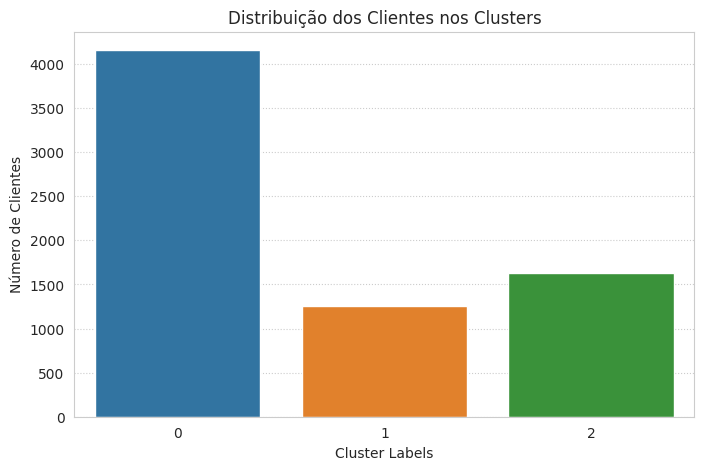

In [164]:
# Contagem de clientes em cada cluster
cluster_counts = telecom_copy['cluster_labels'].value_counts()

# Plot da distribuição dos clusters
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster Labels')
plt.ylabel('Número de Clientes')
plt.title('Distribuição dos Clientes nos Clusters')
plt.show()


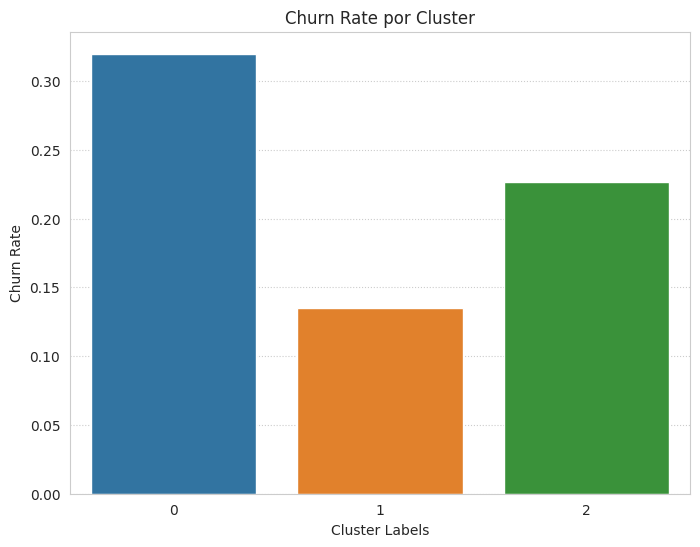

In [165]:
# Calcular a taxa de churn para cada cluster
churn_rate_by_cluster = telecom_copy.groupby('cluster_labels')['end_date_class'].mean()

# Criar o gráfico de boxplot para visualizar o churn rate por cluster
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rate_by_cluster.index, y=churn_rate_by_cluster.values)
plt.xlabel('Cluster Labels')
plt.ylabel('Churn Rate')
plt.title('Churn Rate por Cluster')
plt.show()


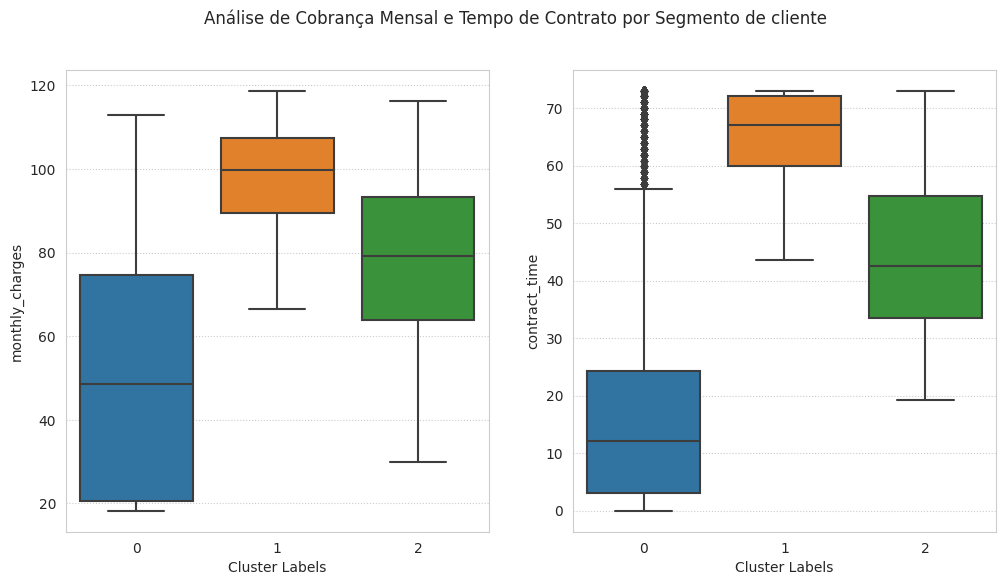

In [166]:
# Selecionar as variáveis relevantes para análise
variables_to_compare = ['monthly_charges', 'contract_time']

# Plot dos boxplots para cada variável em cada cluster
plt.figure(figsize=(12, 6))
for i, var in enumerate(variables_to_compare):
    plt.subplot(1, len(variables_to_compare), i + 1)
    sns.boxplot(x='cluster_labels', y=var, data=telecom_copy)
    plt.xlabel('Cluster Labels')
    plt.ylabel(var)
plt.suptitle('Análise de Cobrança Mensal e Tempo de Contrato por Segmento de cliente')
plt.show()


A análise dos dados por clusters revela diferentes características e comportamentos dos clientes:

* **Seguimento de clientes críticos (cluster 0):** esse grupo é a maioria em nosso dataset com 4.169 clientes. A maioria são adultos de sexo masculino, não possuem parceiros e nem dependentes. O tipo de contrato mais comum entre esses clientes é o contrato mês a mês. Eles não contrataram qualquer serviço de internet e, portanto, nenhum serviço adicional. O tempo de contrato médio é de 18 meses. A taxa de churn nesses clientes é a mais alta chegando a 31%. Esses clientes tem um gasto mensal de 49,67$ e já gastaram com o serviço 684,16$. A receita estimada que esses clientes geram para a empresa é de 207.083,30$ e uma receita média estimada de 11.195,58$.

* **Seguimento de clientes fidelizados(cluster 1):** aqui encontramos 1.256 clientes com contrato de 2 anos e maior média de tempo de contrato certa de 65 meses. São em sua maioria do sexo feminino, adultos, com parceiro e sem dependentes. O principal serviço de internet contratado é a fibra óptica e esses clientes optaram por contratar todos os serviços adicionais. A taxa de churn nesse grupo é a menor com 13%. O gasto mensal desses clientes é de cerca de 97,98$ e total 6.295$. Esses clientes geram uma receita média de 123.066,05$ e receita estimada mensal de 1883,31$

* **Seguimento de clientes estáveis(cluster 2):** Com 1618 clientes, esse grupo é composto por clientes com tipo de contrato mês a mês  e média de tempo de contrato de 44 meses. São clientes do sexo masculino, com parceiro e sem dependentes. Principal tipo de serviço de internet contratado foi a fibra óptica e assinaram quase todos os serviços adicionais, exceto pelo suporte técnico. A taxa de churn desses clientes é de 22%, o gasto mensal é de 77,85$ e total de 3.274,02$. A receita estimada gerada é de 125.967$ e mensal estimada de 2819,3$

In [167]:
# Criar uma coluna que indica se o cliente assinou pelo menos um dos serviços adicionais
additional_services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# Definir uma função para verificar a condição em cada linha
def has_additional_services(row):
    if row['internet_service'] == 'not contracted':
        return False
    return row[additional_services].any()

# Aplicar a função à coluna 'has_additional_services'
telecom_copy['has_additional_services'] = telecom_copy.apply(has_additional_services, axis=1)


# Criar colunas para os outros serviços de internet
telecom_copy['has_additional_services_dsl'] = (telecom_copy['internet_service'] == 'DSL') & telecom_copy['has_additional_services']
telecom_copy['has_additional_services_fiber_optic'] = (telecom_copy['internet_service'] == 'Fiber optic') & telecom_copy['has_additional_services']


In [168]:
cat_bin.append('has_additional_services_dsl')
cat_bin.append('has_additional_services_fiber_optic')
cat_bin.append('has_additional_services')
cat_bin

['paperless_billing',
 'gender',
 'partner',
 'dependents',
 'senior_citizen',
 'has_additional_services_dsl',
 'has_additional_services_fiber_optic',
 'has_additional_services']

In [169]:
def plot_categorical_churn(data, col):
    # Calculando o percentual de churn e não churn por categoria
    percentages = data.groupby([col, 'end_date_class']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)
    
    # Plotando o gráfico de barras empilhadas
    fig, ax = plt.subplots(figsize=(16, 8))

    sns.barplot(data=percentages.reset_index().melt(id_vars=col, value_name='percentage', var_name='end_date_class'),
                x=col, y='percentage', hue='end_date_class', ax=ax)

    plt.xlabel(col, fontsize=16)
    plt.ylabel('Porcentagens', fontsize=16)
    plt.title(f'Porcentagem de Não-Churn e Churn por {col}', fontsize=18)

    # Ajustando os tamanhos das fontes nos ticks e nos percentuais
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(rotation=0)  

    # Adicionando rótulos de percentual nas barras
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=16,
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8', alpha=0.5))

    legend_labels = ['No', 'Yes']
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, legend_labels, title='Churn', fontsize=15)

    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()

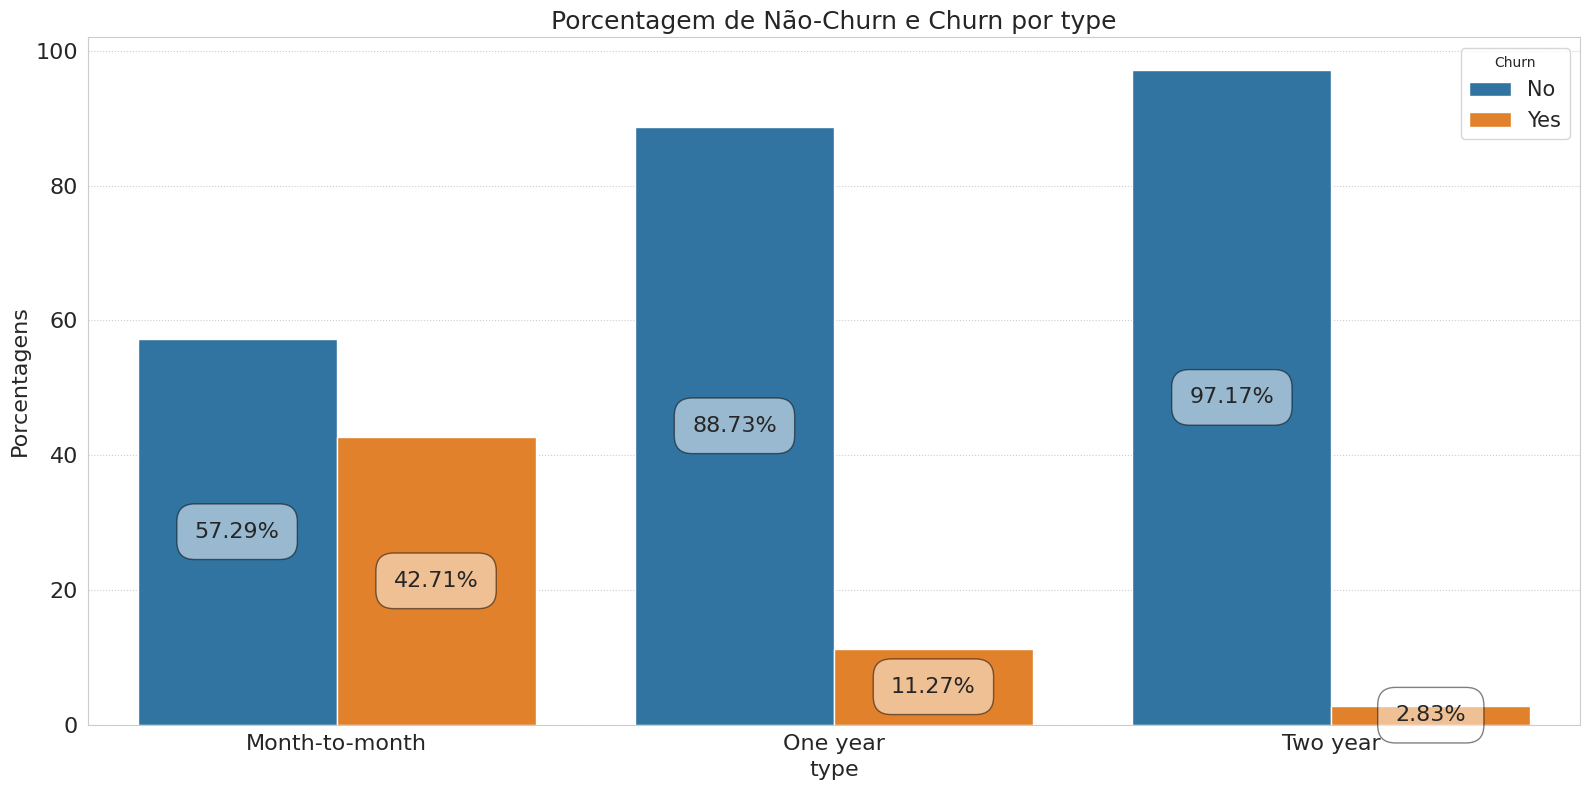

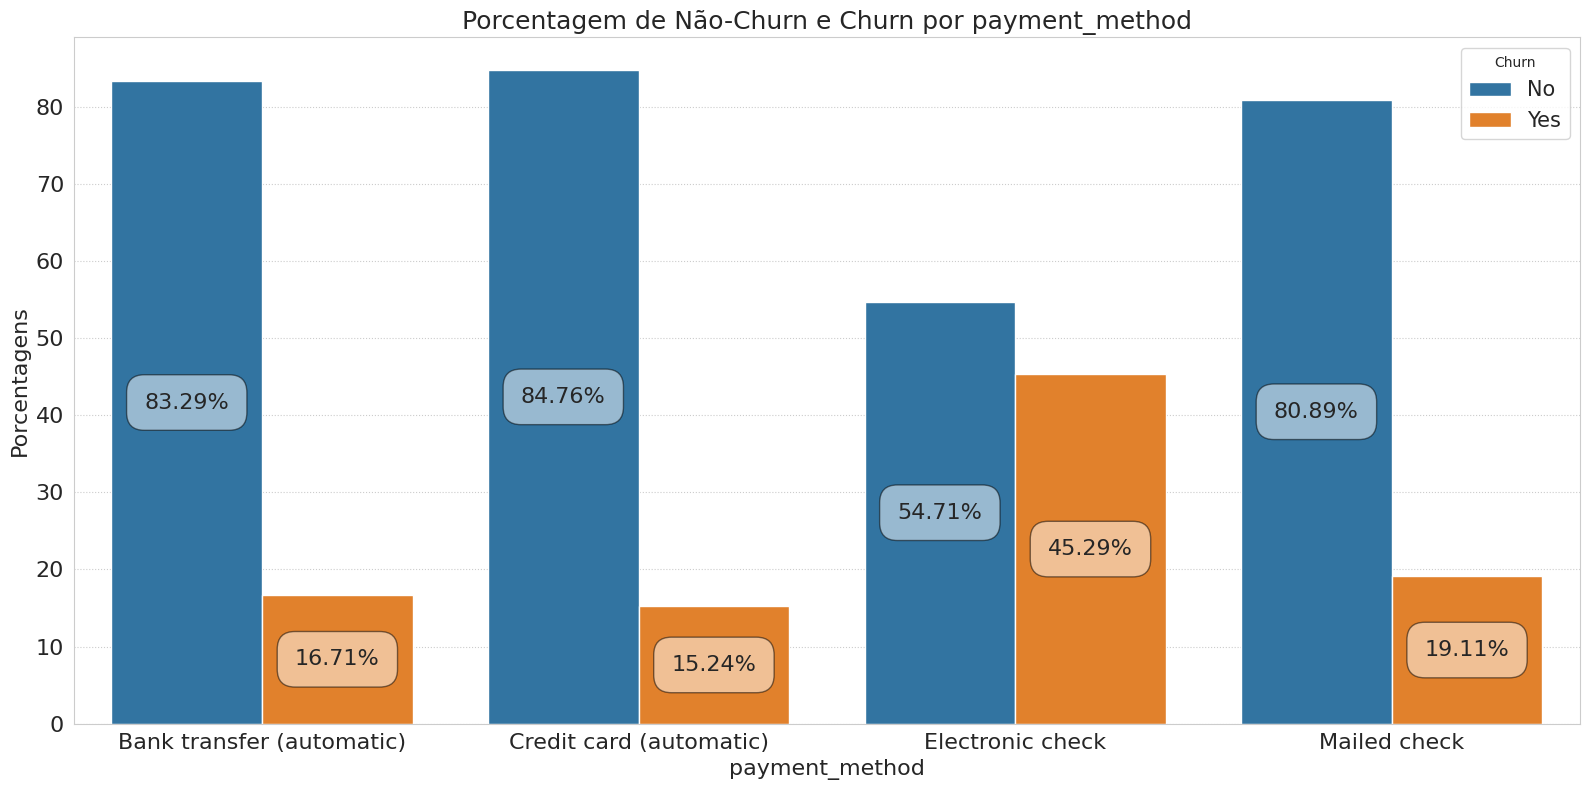

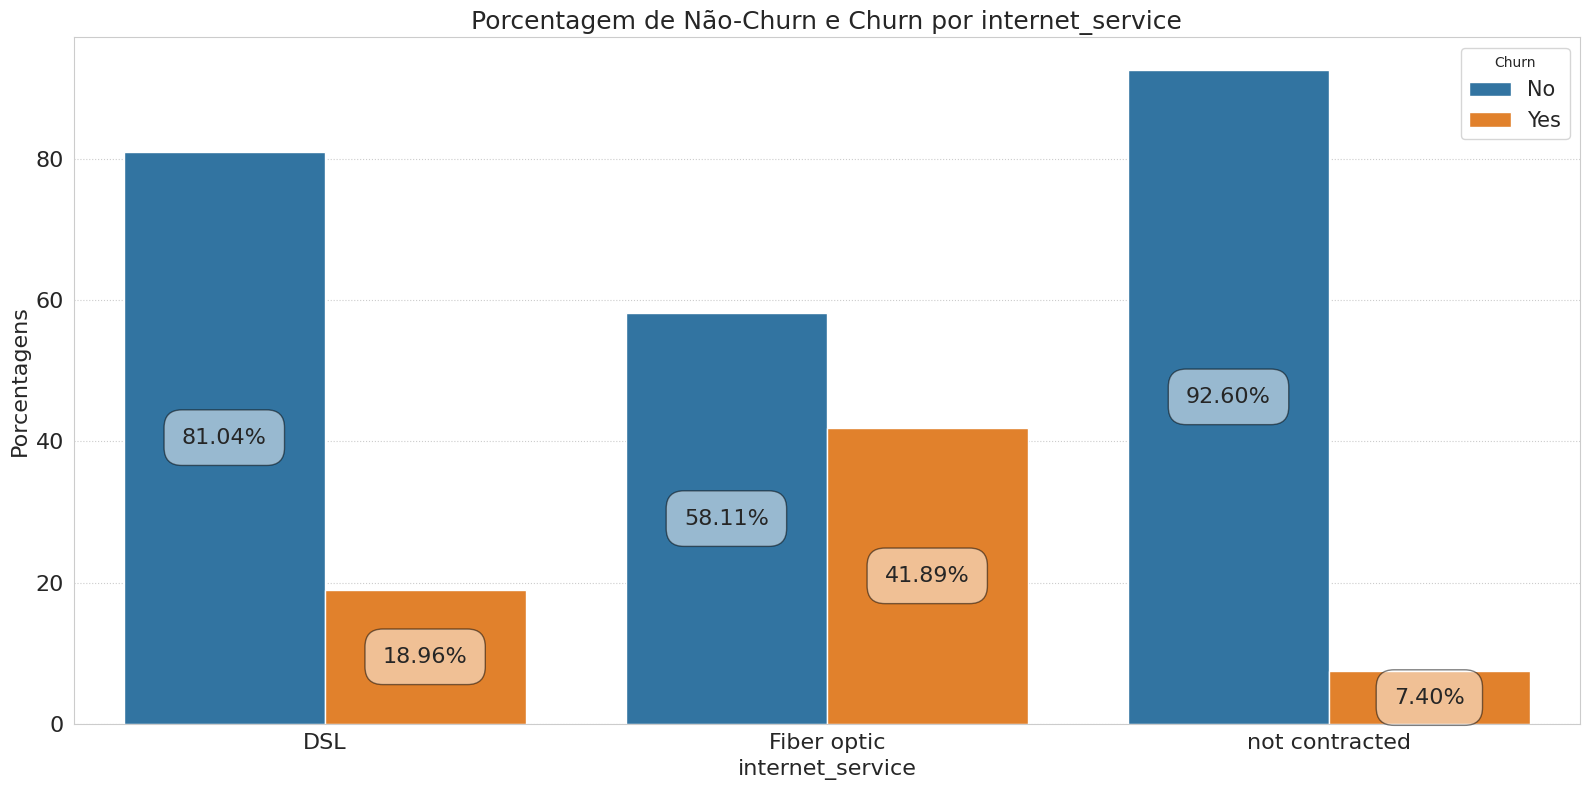

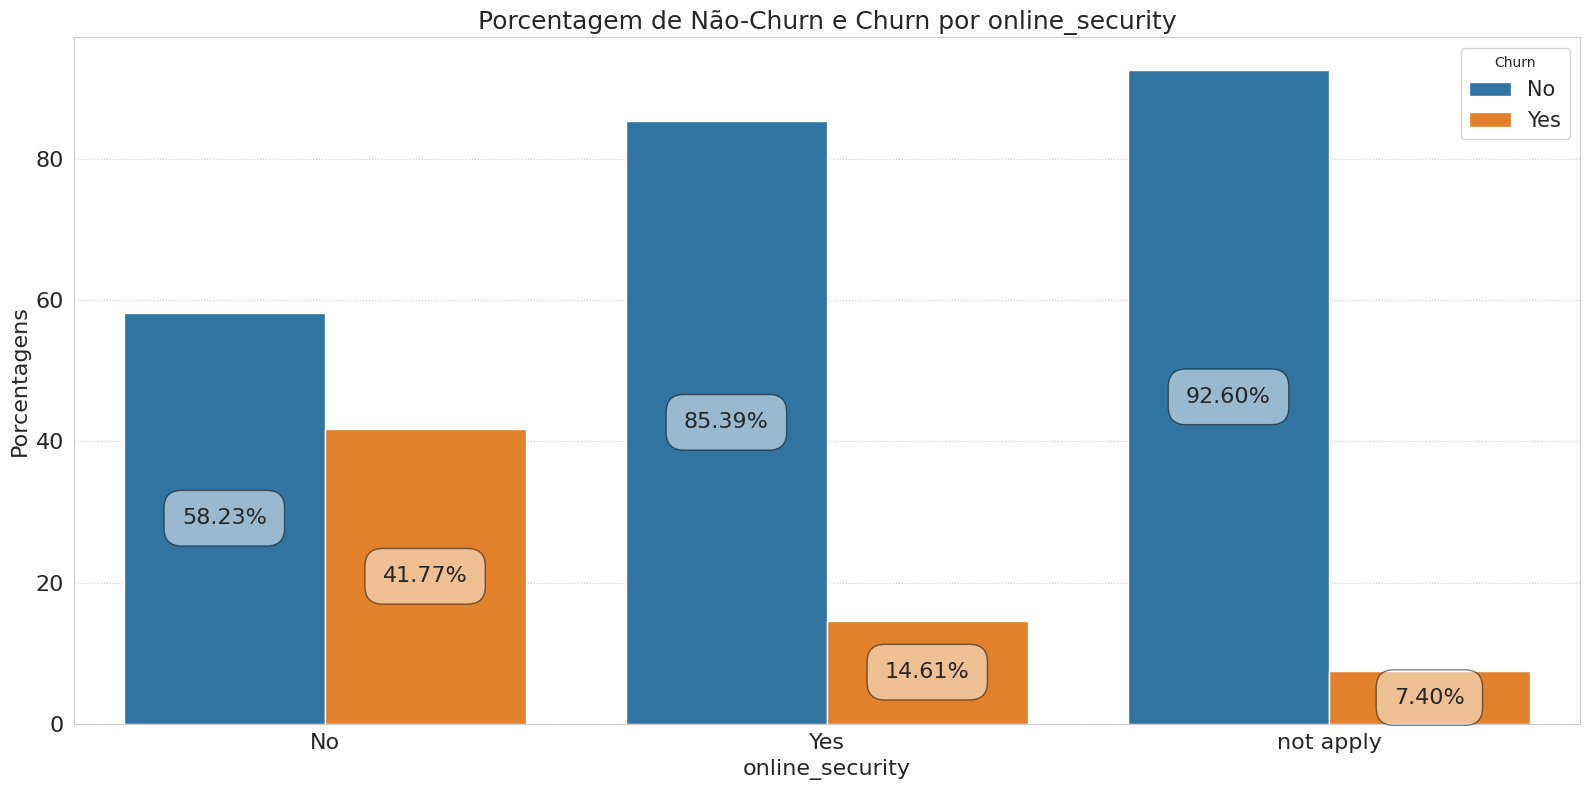

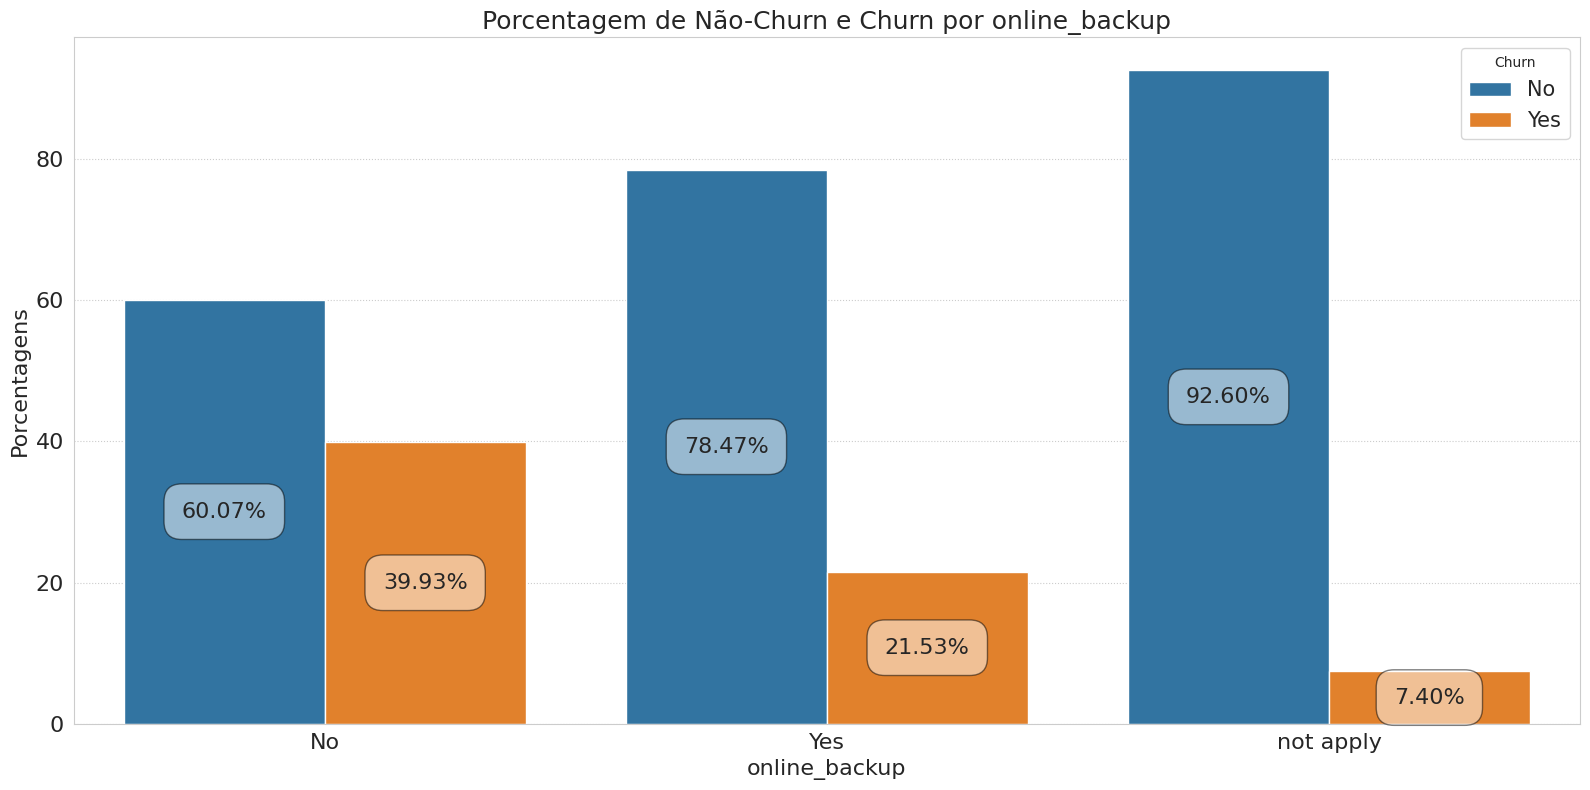

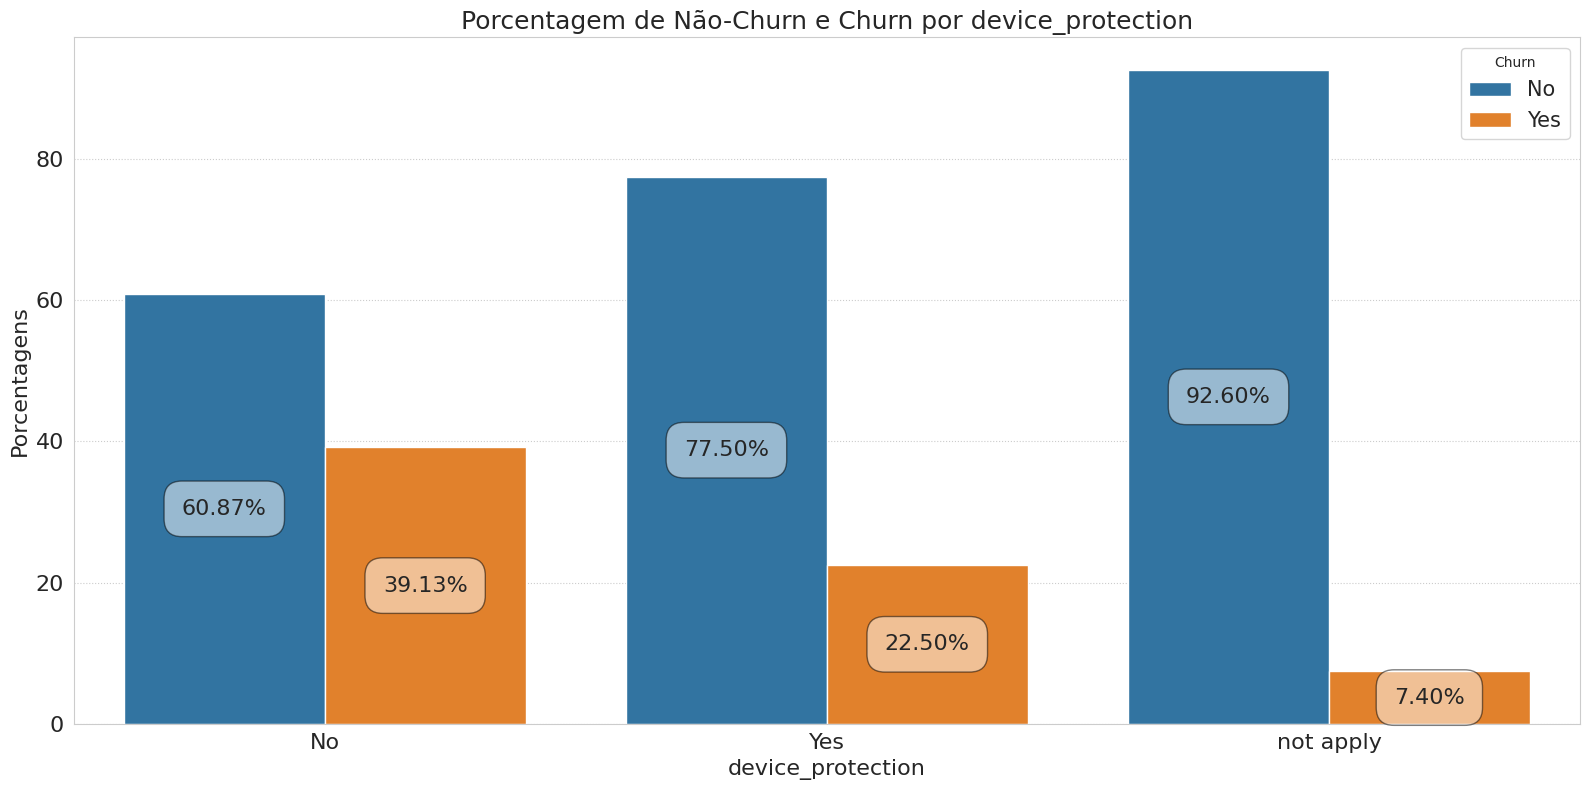

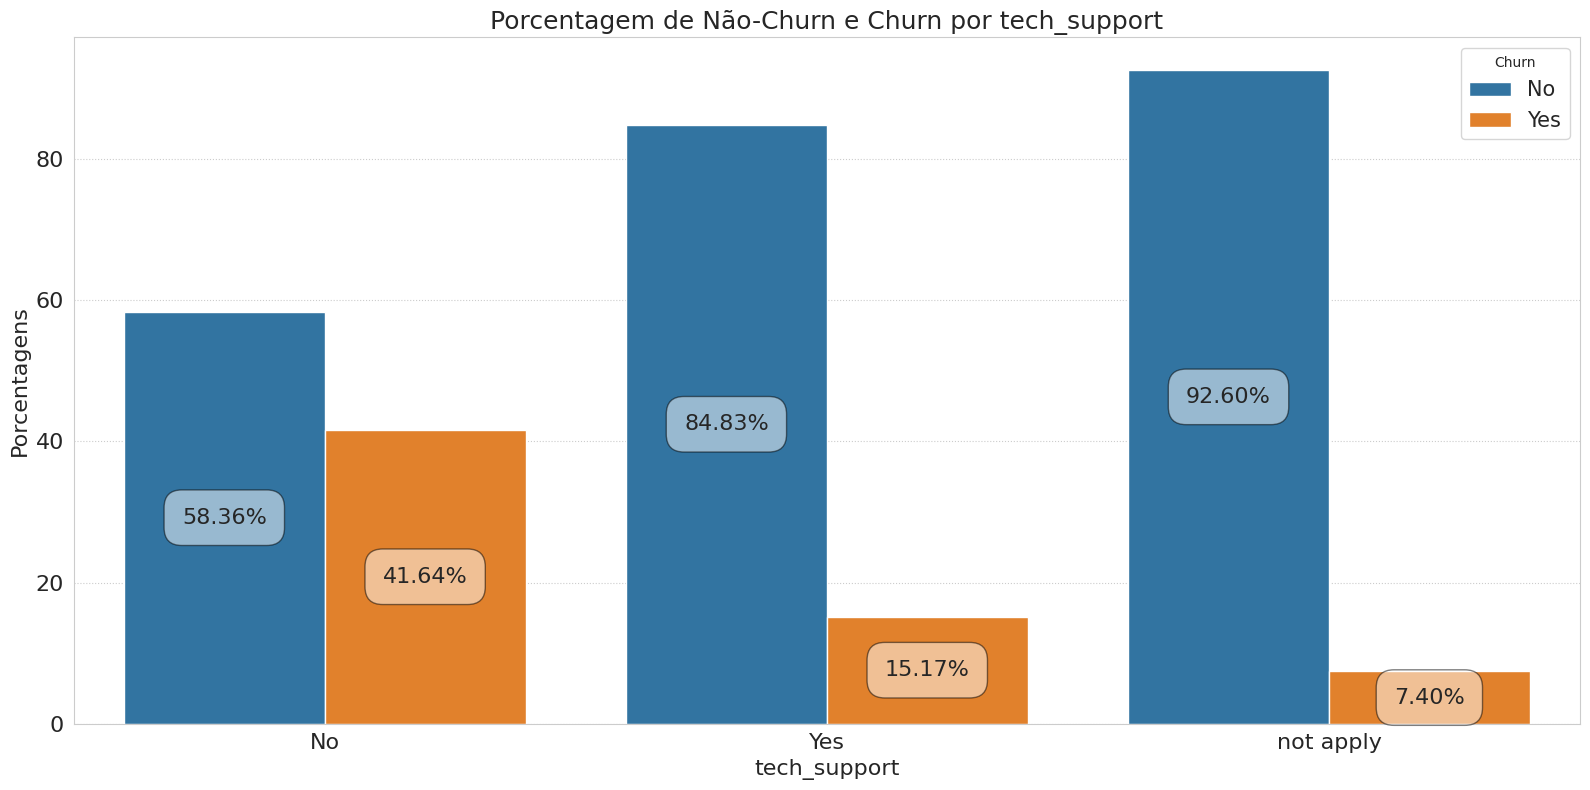

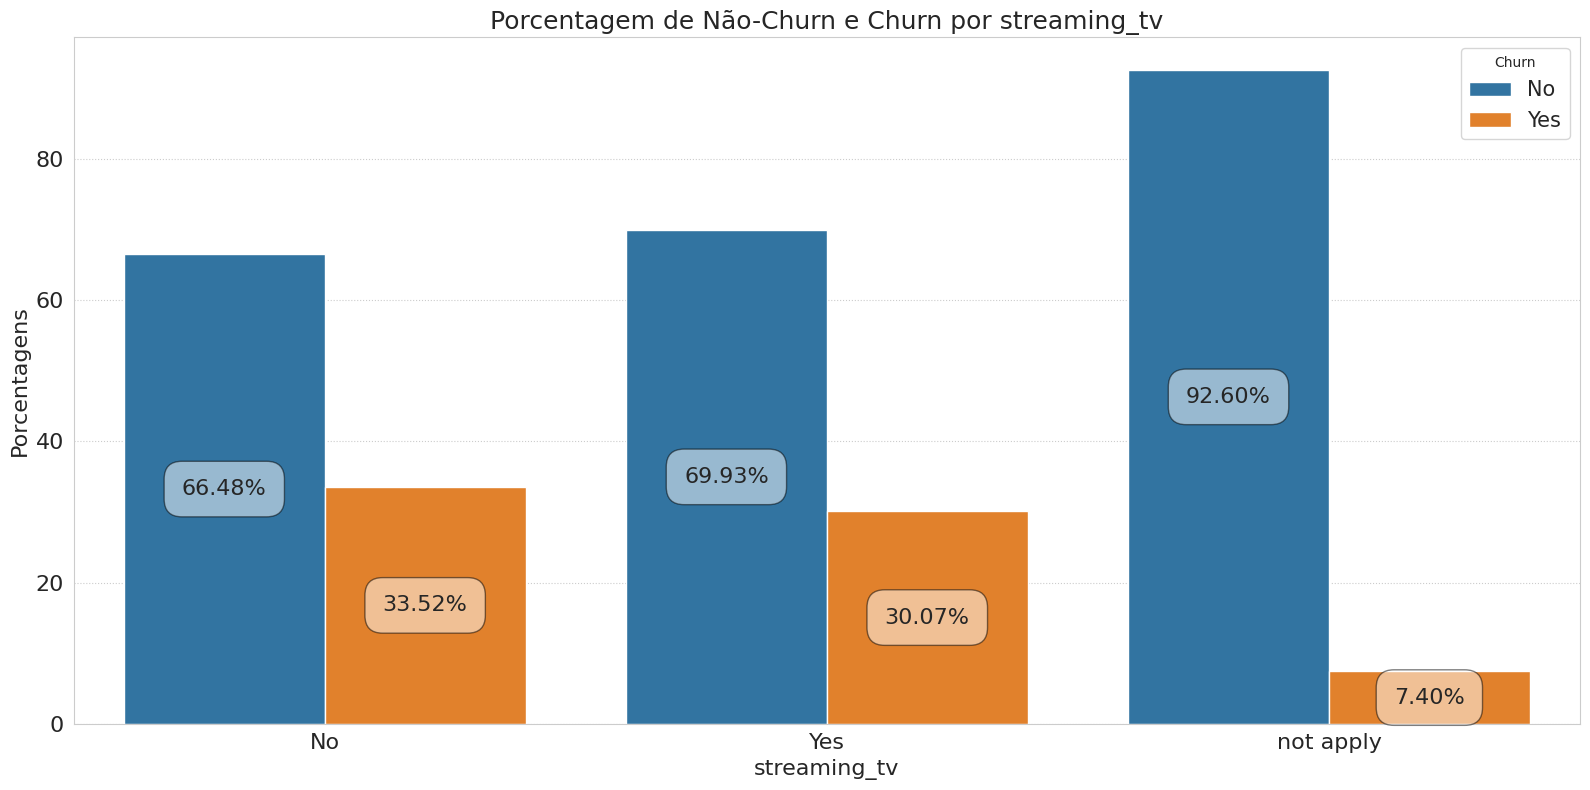

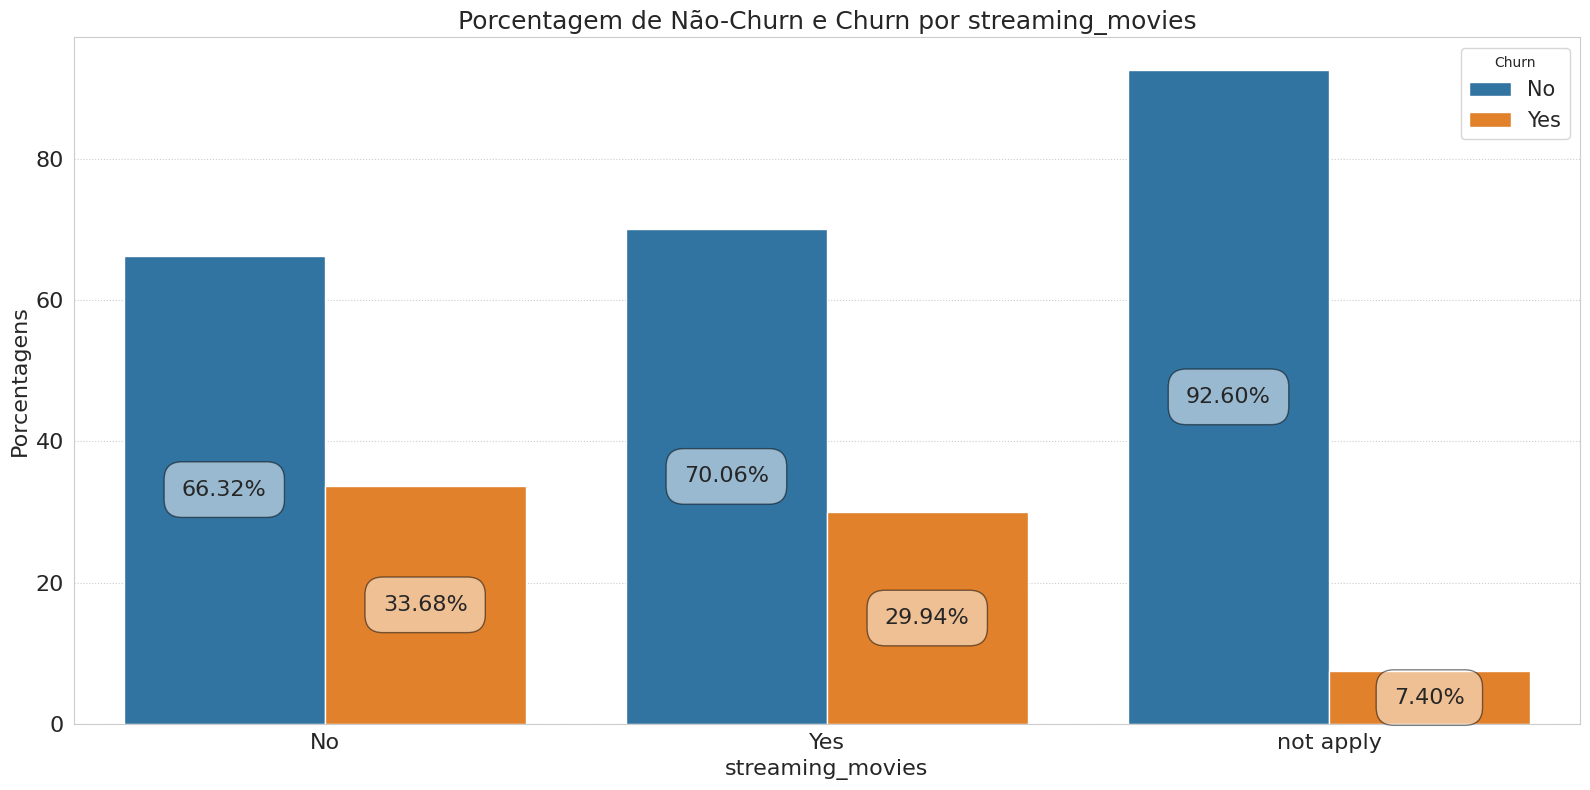

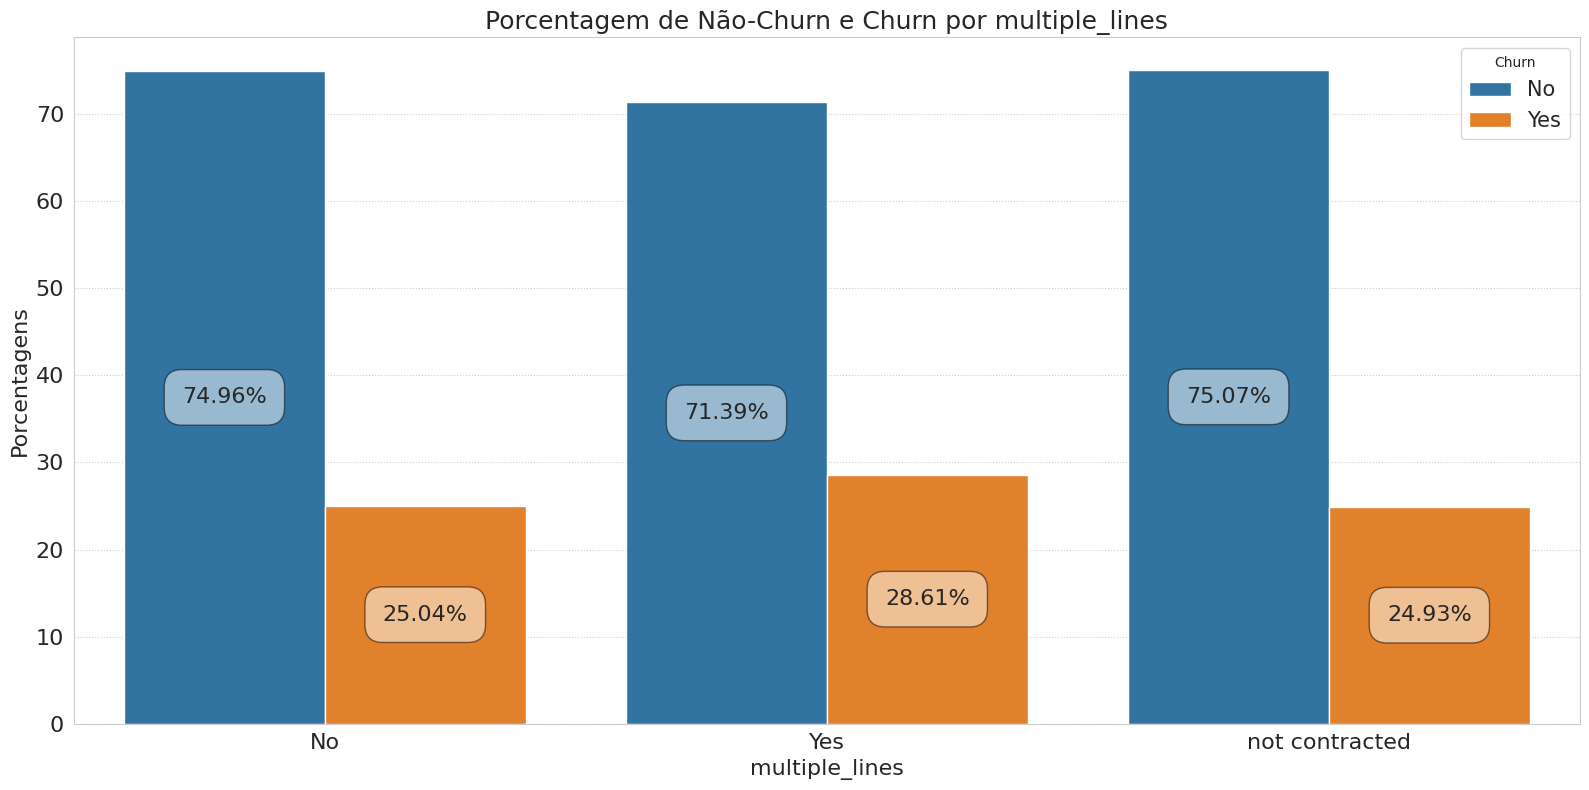

In [170]:
for col in cat_cols:
    plot_categorical_churn(telecom_copy, col)

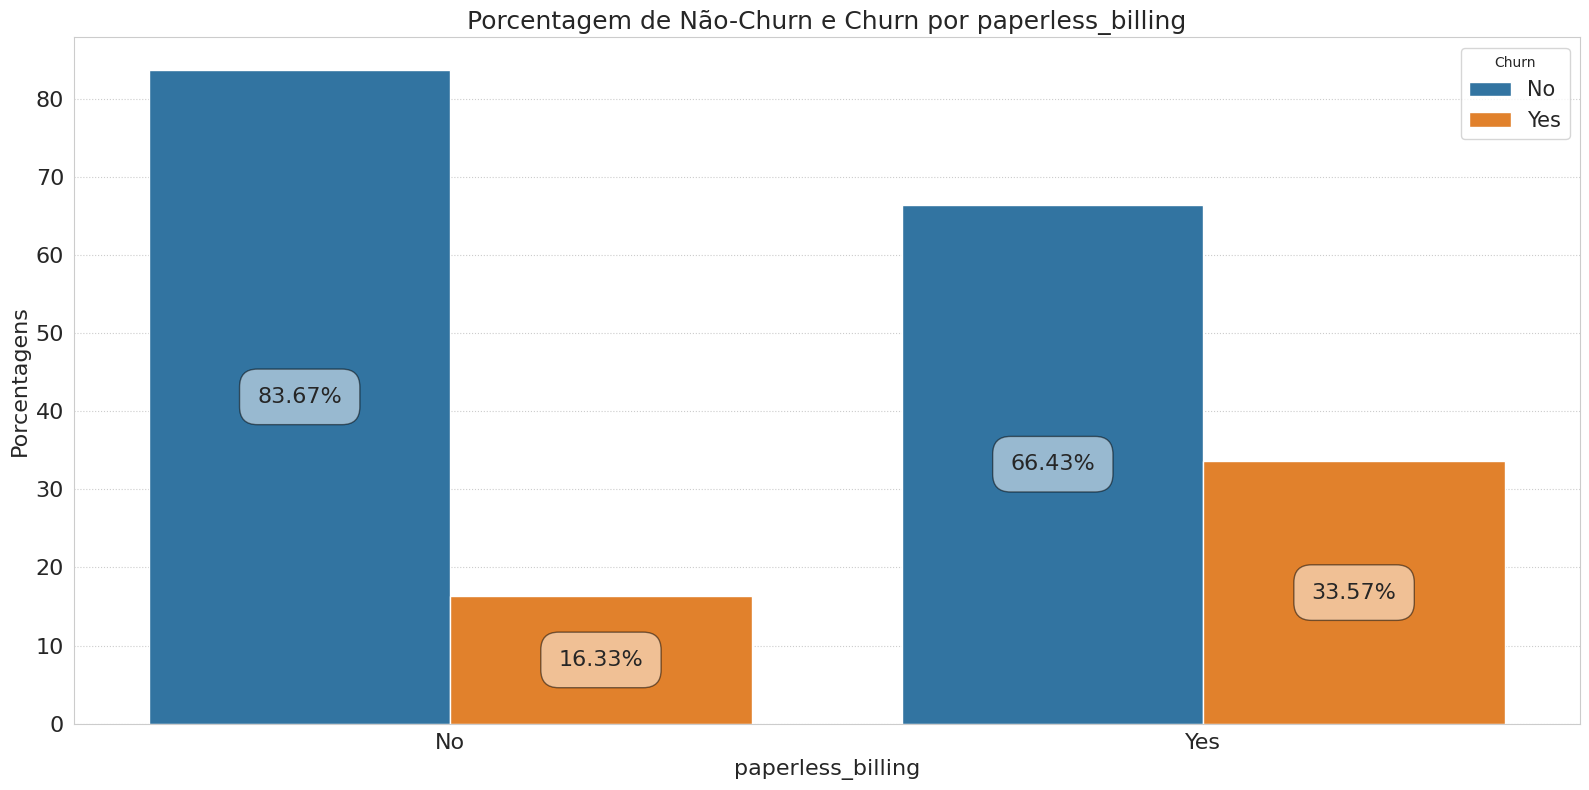

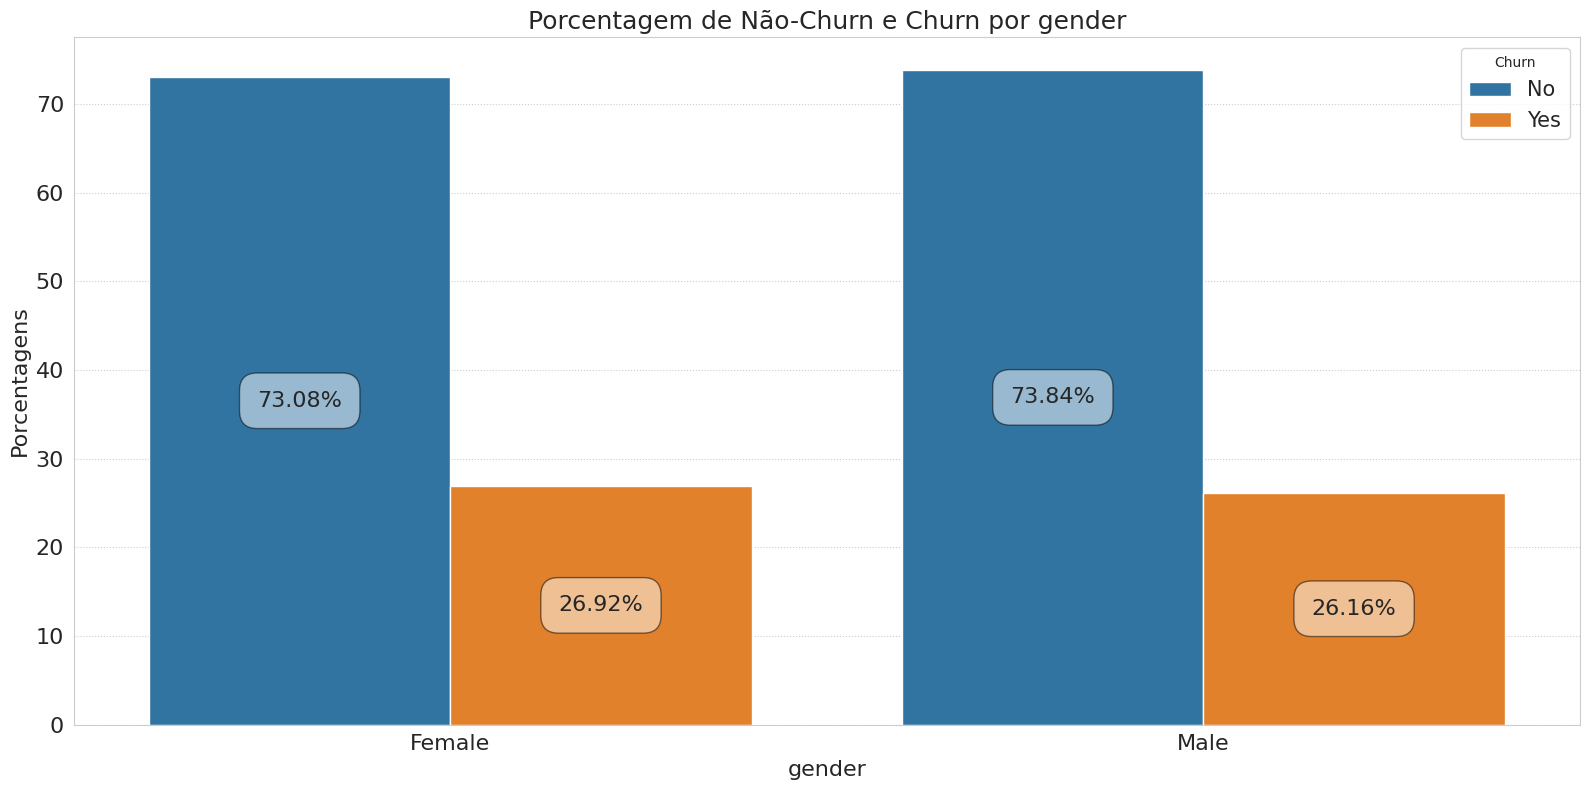

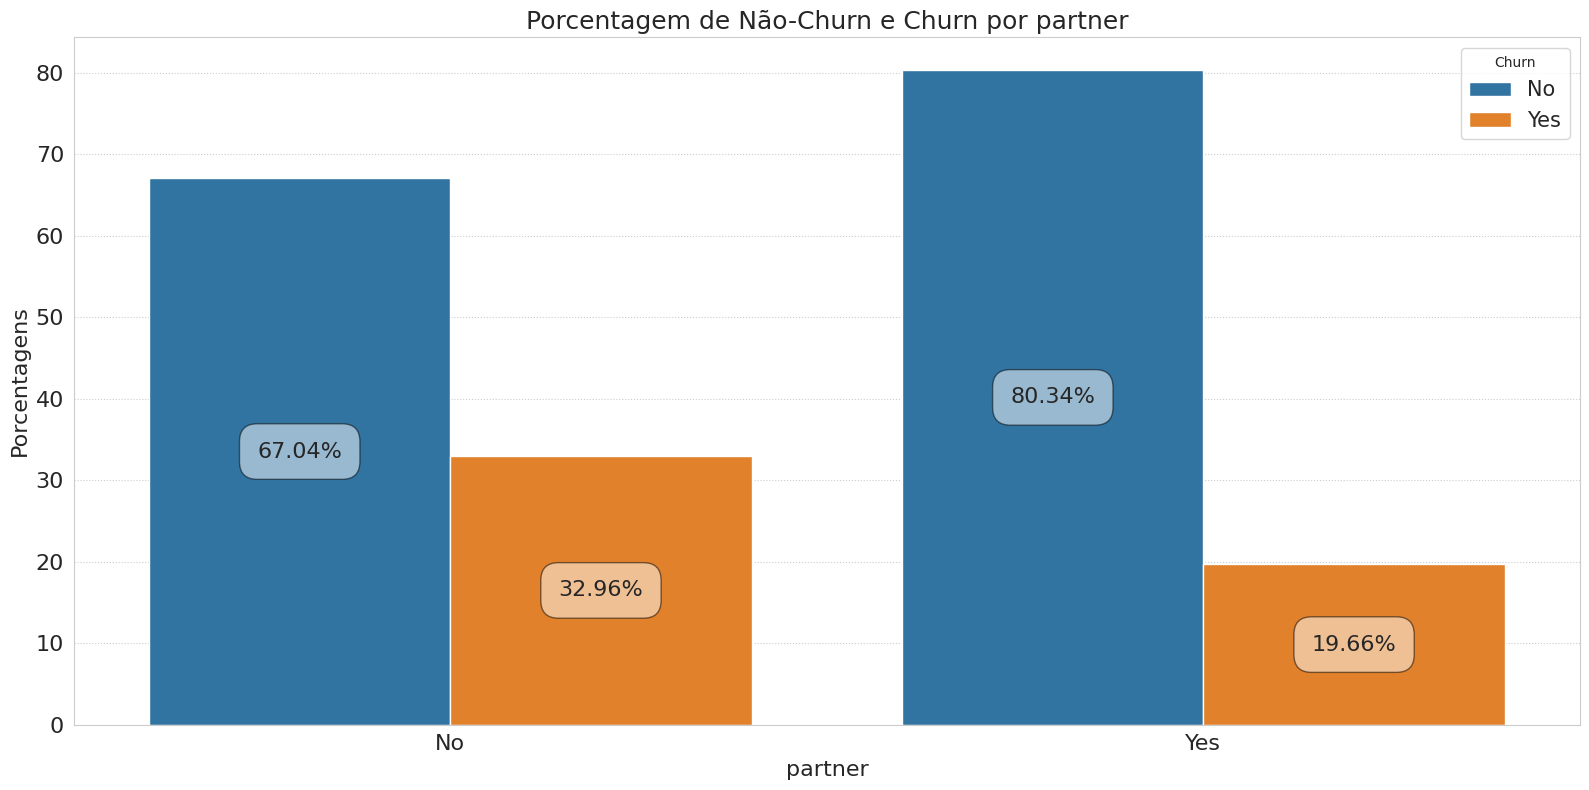

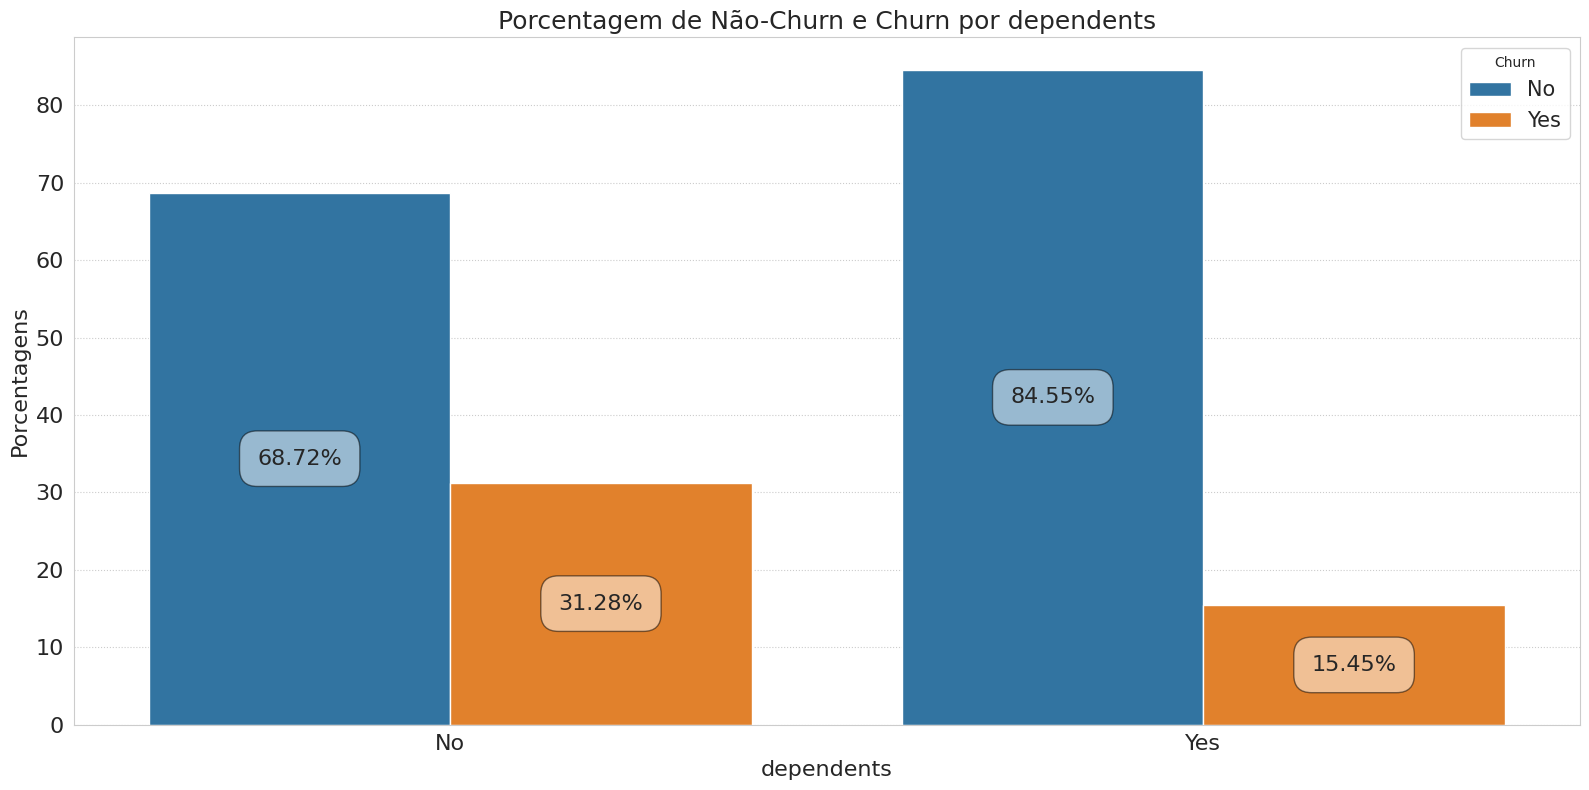

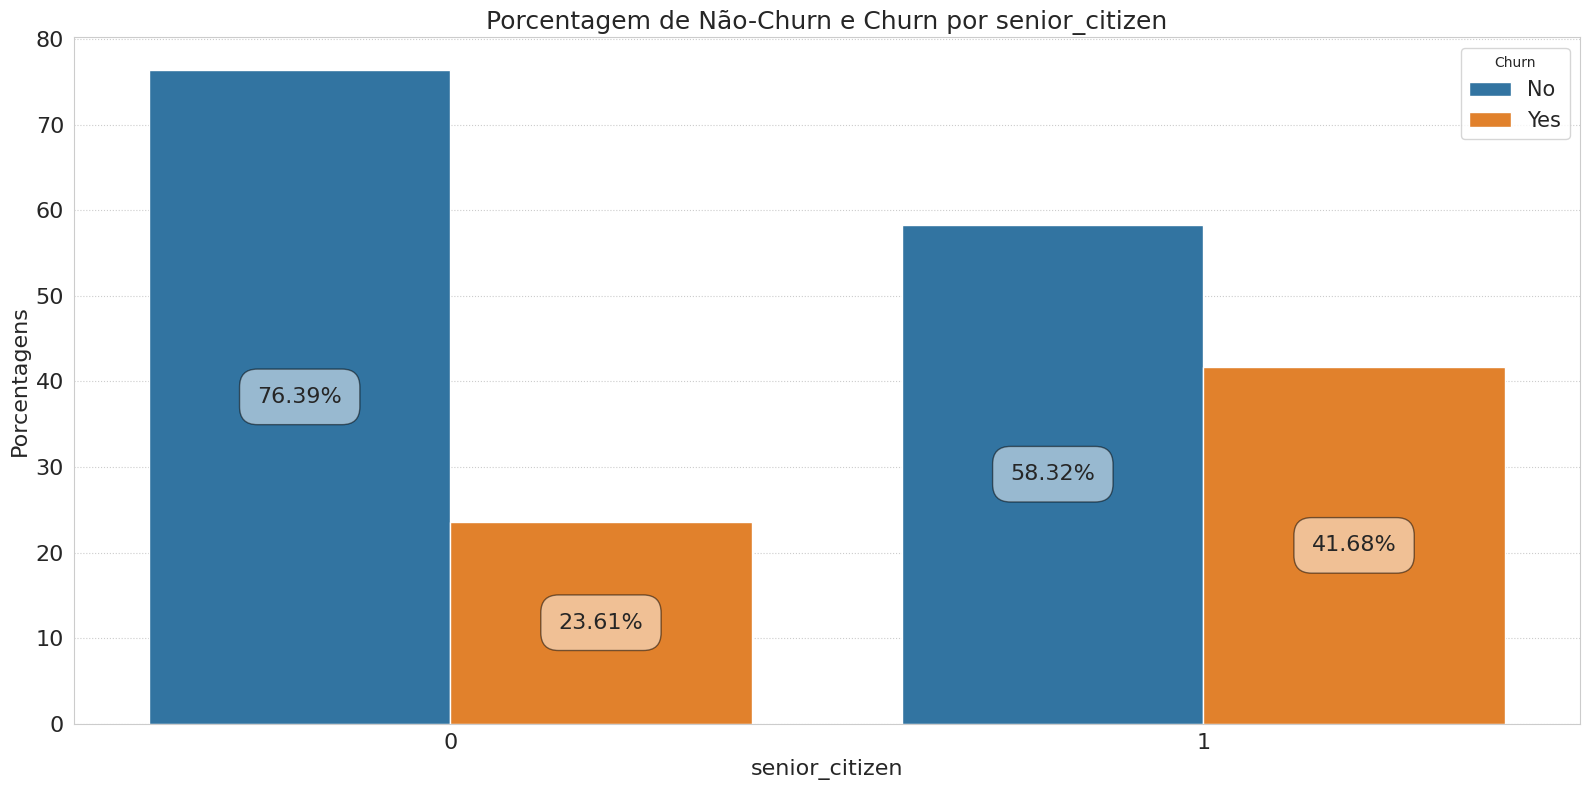

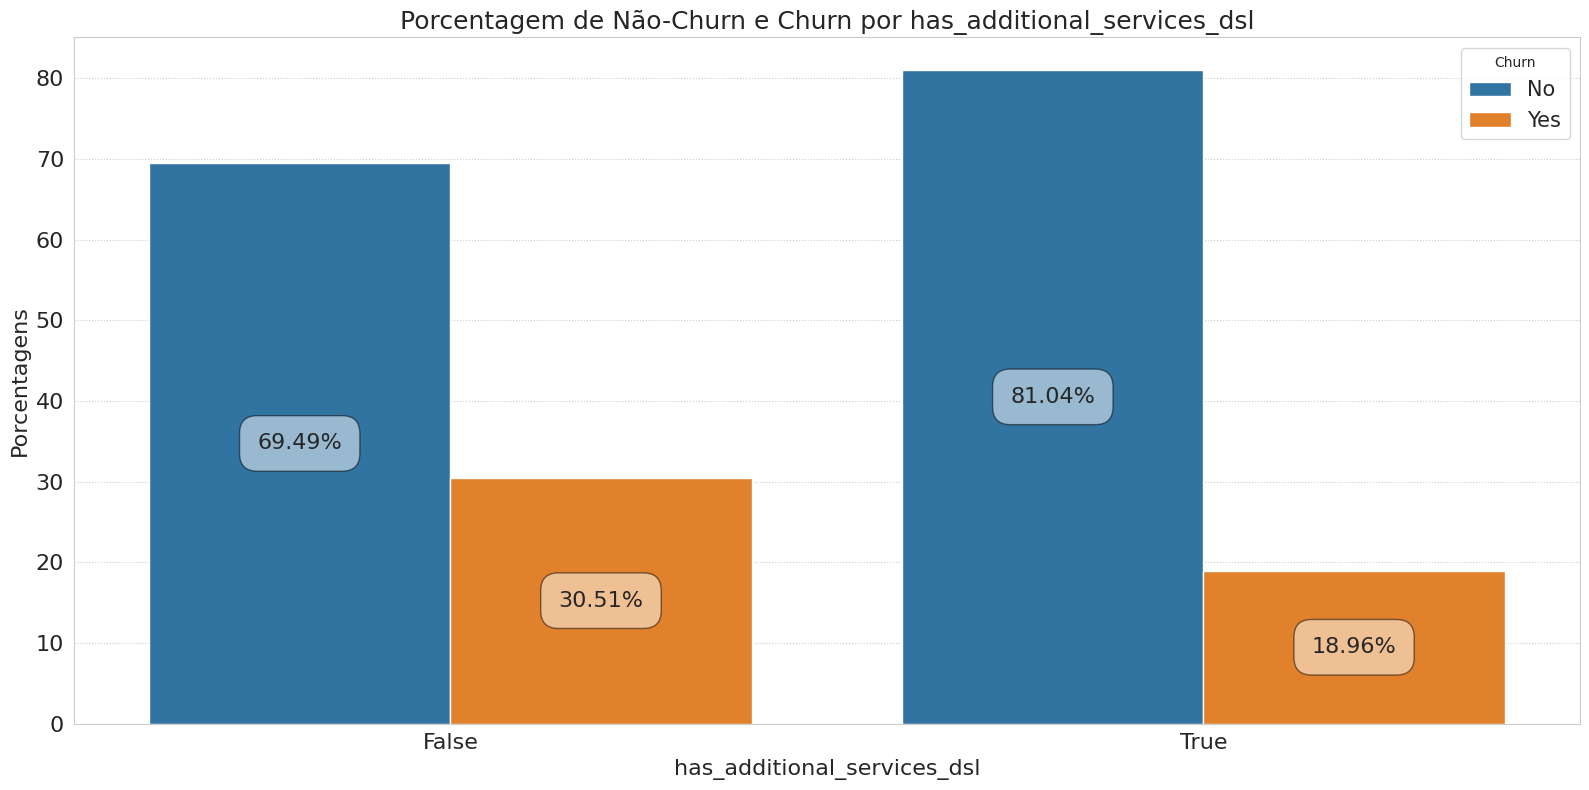

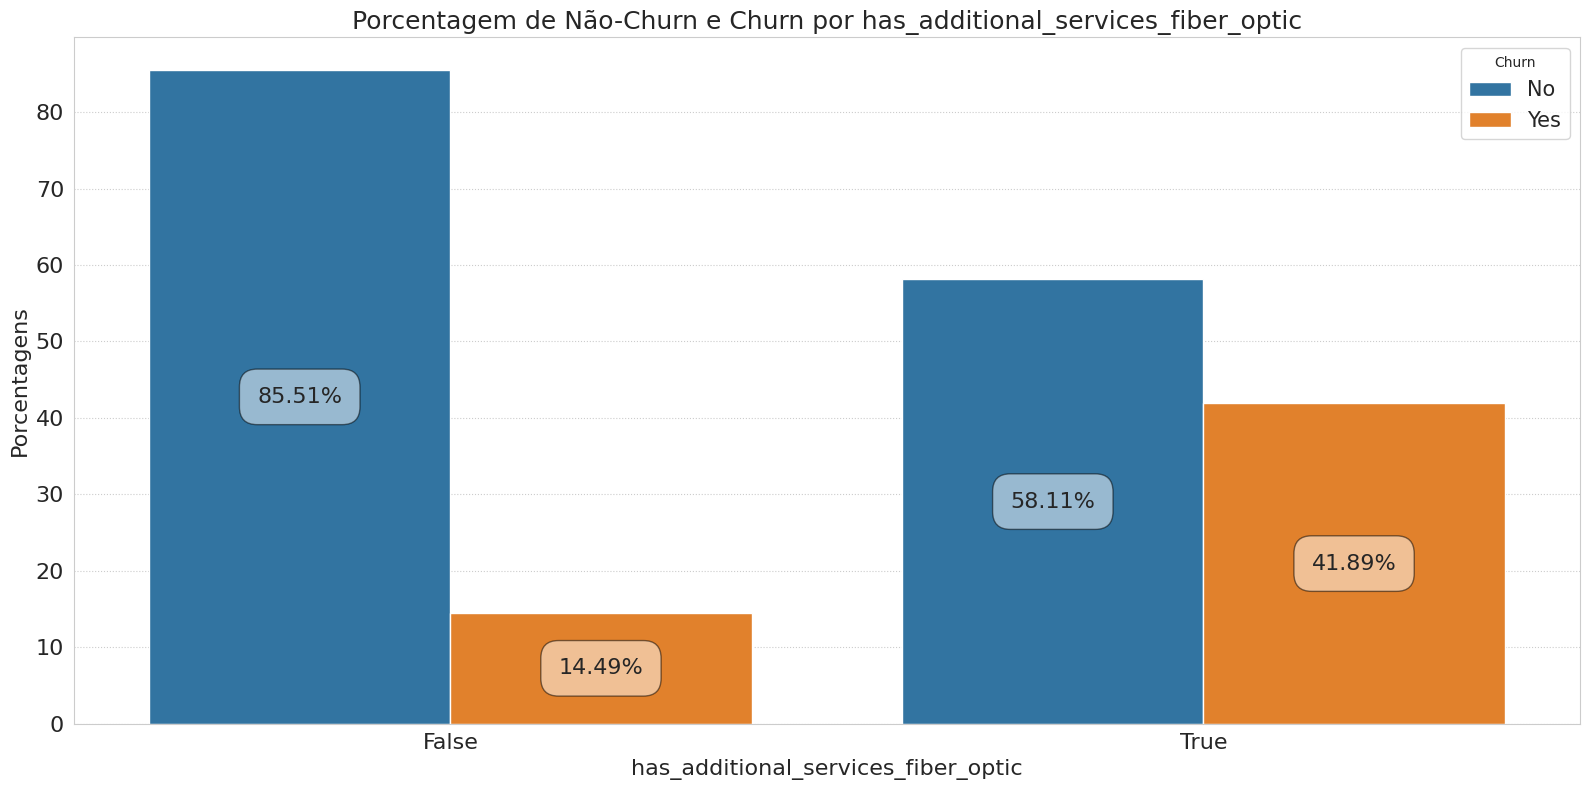

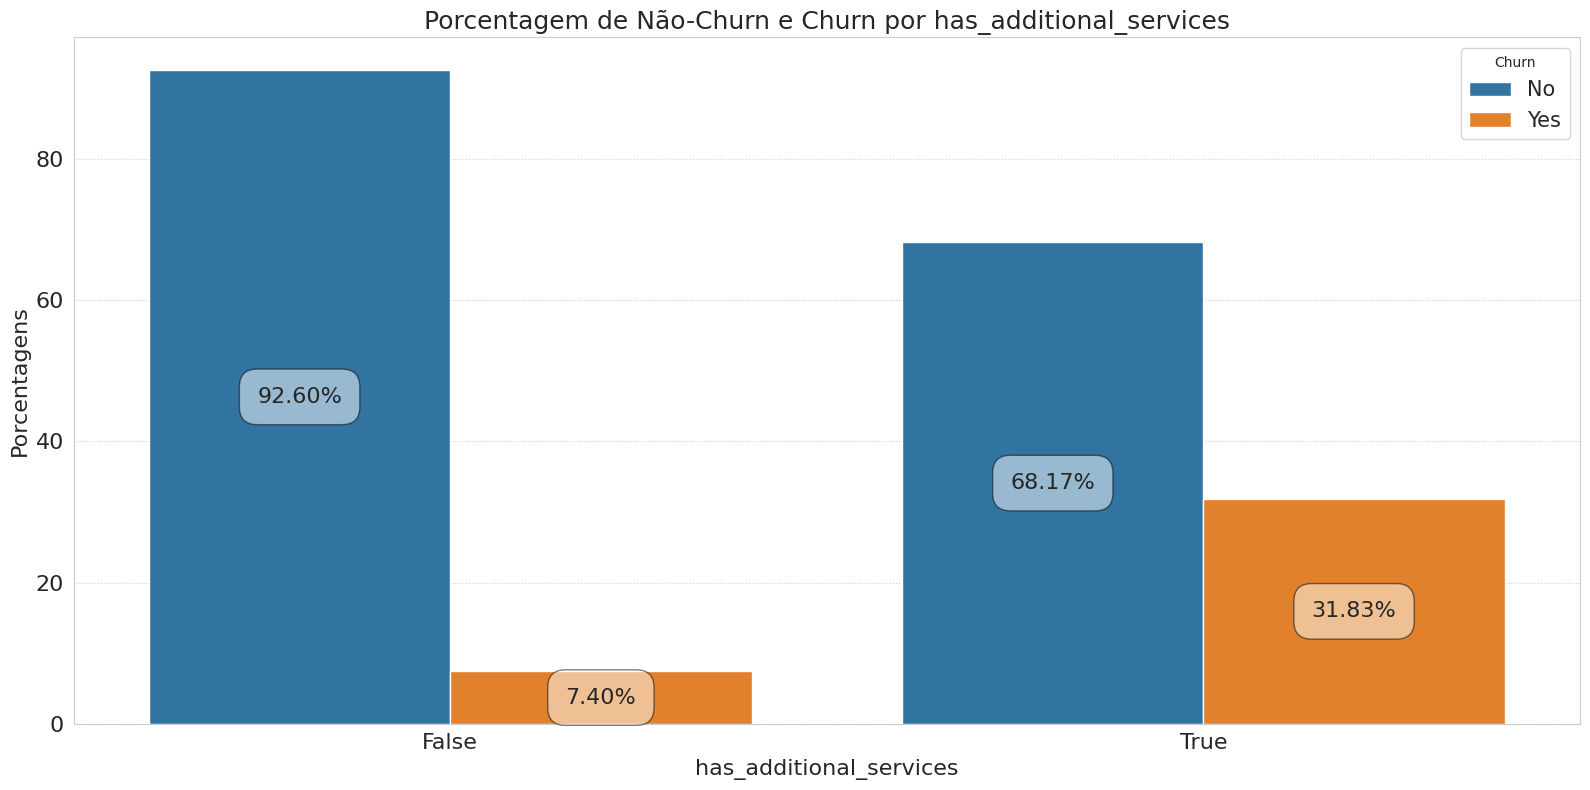

In [171]:
for col in cat_bin:
    plot_categorical_churn(telecom_copy, col)

**De um modo geral é possível ver que a maioria dos clientes do:**

* **Grupo Não-Churn:**

    * É composto por adultos, homens, com companheiro e sem dependentes. Há dois subgrupos de clientes aqueles que tem cobrança mensal maior e os que tem cobrança mensal menor. Esses clientes optam por fatura sem papel e preferem o pagamento mensal por check eletrônico. A maioria optou por não contratar serviço de internet, e o que assinaram por tal serviço escolheram do tipo DSL e por quase todos os serviços extras, exceto pela linha dedicada de suporte técnico. A maioria não possui múltiplas redes de telefonia.

* **Grupo Churn:**

    * São, em sua maioria, idosos, não possuem nem companheiro e nem dependentes. A cobrança mensal desses clientes estão concentradas em valores maiores. A maioria optou pelo pagamento mensal por cheque enviado e preferiram fatura sem papel. O tipo de serviço de internet mais contratado é a fibra ótica, porém, escolheram não contratar nenhum dos serviços extras.


### Codificando variáveis categoricas

In [172]:
def encoding_variables(data, col):
    data[col] = data[col].astype('category').cat.codes

In [173]:
for col in cat_cols:
    encoding_variables(telecom_copy, col)

In [174]:
for col in cat_bin:
    encoding_variables(telecom_copy, col)

In [175]:
telecom_copy.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,streaming_tv,streaming_movies,multiple_lines,contract_time,end_date_class,interaction_contract_monthly,cluster_labels,has_additional_services,has_additional_services_dsl,has_additional_services_fiber_optic
0,7590-VHVEG,2020-01-01,NaT,0,1,2,29.85,29.85,0,0,...,0,0,2,1.033333,0,30.845000,0,1,1,0
1,5575-GNVDE,2017-04-01,NaT,1,0,3,56.95,1889.50,1,0,...,0,0,0,34.533333,0,1966.673333,0,1,1,0
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,3,53.85,108.15,1,0,...,0,0,0,2.033333,1,109.495000,0,1,1,0
3,7795-CFOCW,2016-05-01,NaT,1,0,0,42.30,1840.75,1,0,...,0,0,2,45.700000,0,1933.110000,0,1,1,0
4,9237-HQITU,2019-09-01,2019-11-01,0,1,2,70.70,151.65,0,0,...,0,0,0,2.033333,1,143.756667,0,1,0,1


### Correlação entre variáveis

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


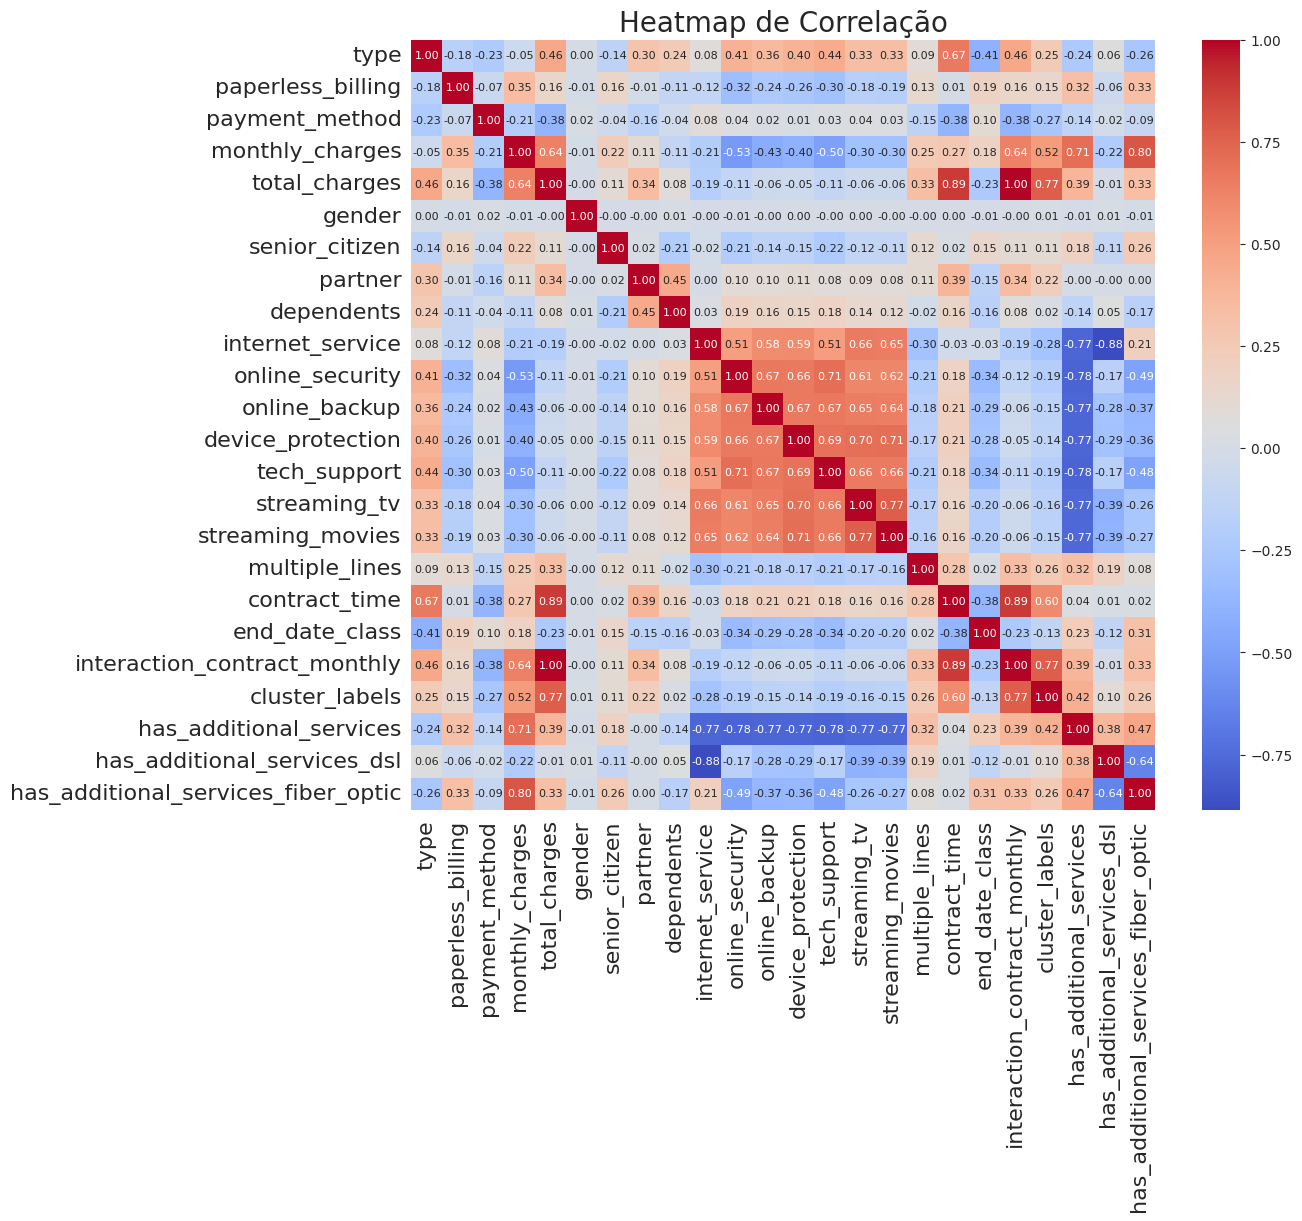

In [176]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(telecom_copy.corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', ax=ax, annot_kws={"fontsize": 8})

ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.title('Heatmap de Correlação', fontsize=20)
plt.show()


* A partir das informações presentes no heatmap vemos correlações moderadas a altas (>= 6):

    * Existe uma correlação positiva moderada (r = 0,67) entre o tipo de contrato e o tempo de contrato. Isso sugere que os clientes com contratos de longo prazo tendem a ter tempos de contrato mais longos.

    * Há uma correlação positiva moderada (r = 0,64) entre a cobrança mensal e o gasto total com os serviços. Isso indica que clientes com cobranças mensais mais altas também tendem a ter maiores gastos totais com os serviços.

    * Observa-se uma correlação positiva forte (r = 0,89) entre o gasto total com os serviços e o tempo de contrato. Isso significa que clientes com tempos de contrato mais longos tendem a ter gastos totais mais altos com os serviços.

    * É possível identificar uma correlação positiva moderada (r = 0,66) entre o serviço de internet e os serviços de streaming de TV e filmes. Isso sugere que os clientes que contratam serviços de internet têm maior probabilidade de utilizar serviços de streaming.

    * Existem correlações positivas moderadas entre recursos adicionais, como segurança online, backup online, proteção de dispositivo e suporte técnico, com os serviços de streaming (r = 0,61 e 0,71). Isso indica que os clientes que utilizam esses recursos adicionais também têm maior probabilidade de utilizar serviços de streaming.

## Feature Selection

Através do estudo das features realizado anteiormente é possível dizer que:

* A variáveis 'customer_id', que armazenda o código unívoco  de cada cliente, nada informa sobre a variável de interesse (churn).

* A variável 'gender' parece não apresentar quantidades expressivamente diferentes em cada grupo, como mostra o gráfico.

* Para completar a etapa de seleção de features verei se há relação entre cada variável e os grupos(churn, não-churn).

In [177]:
# Classe que tem como módulos os calculos de teste estatístico específico para cada variável 
class StatTests:
    def __init__(self, alpha=0.05):
        self.alpha = alpha

    # Estatística F para determinar se as  variâncias são diferentes ou não
    def f_test(self, group1, group2):
        f = np.var(group1, ddof=1) / np.var(group2, ddof=1)
        nun = group1.size - 1
        dun = group2.size - 1
        p_value = 1 - st.f.cdf(f, nun, dun)
        print(f'valor p: {p_value}')
        if p_value < self.alpha:
            return 'As variâncias são diferentes'
        else:
            return 'As variâncias não são diferentes'

    # Teste t  para amostras independentes para variáveis independentes 
    # Cada variável tem >30 observações
    # O parâmetro equal_var tem como padrão True, mas é possível mudar caso 
    # a estatśtica f resulte em variâncias diferentes
    def t_test(self, group1, group2, equal_var=True):
        t, p_value = st.ttest_ind(group1, group2, equal_var=equal_var)
        print(f'Teste T: {t}, valor p: {p_value}')
        if p_value < self.alpha:
            return 'As médias são diferentes'
        else:
            return 'As médias não são diferentes'

    # Teste qui-quadrado para associação entre variáveis categoricas
    def chi2_test(self, group1, group2):
        contingency_table = pd.crosstab(group1, group2)
        chi2, p_value, _, _ = st.chi2_contingency(contingency_table)
        if p_value < self.alpha:
            return 'Há associação entre as variáveis (dependentes)'
        else:
            return 'Não há associação entre as variáveis(independentes)'

In [178]:
# Setando o valor de alpha 5%
alpha = 0.05
# Instanciando a classe
data = StatTests(alpha)

In [179]:
cat_num_test = cat_num
cat_num_test.pop(0)

'begin_date'

In [180]:
grupo1 = telecom_copy['end_date_class']

In [181]:
for var in cat_num:
    grupo2 = telecom_copy[var]
    u_result = data.f_test(grupo1, grupo2)
    print(f"Variável: {var}")
    print(f"Resultado: {u_result}")
    print()

valor p: 1.0
Variável: monthly_charges
Resultado: As variâncias não são diferentes

valor p: 1.0
Variável: total_charges
Resultado: As variâncias não são diferentes

valor p: 1.0
Variável: contract_time
Resultado: As variâncias não são diferentes



In [182]:
for var in cat_num:
    grupo2 = telecom_copy[var]
    t_result = data.t_test(grupo1, grupo2)
    print(f"Variável: {var}")
    print(f"Resultado: {t_result}")
    print()

Teste T: -179.8639691593982, valor p: 0.0
Variável: monthly_charges
Resultado: As médias são diferentes

Teste T: -84.39182315053061, valor p: 0.0
Variável: total_charges
Resultado: As médias são diferentes

Teste T: -109.77485504907307, valor p: 0.0
Variável: contract_time
Resultado: As médias são diferentes



In [183]:
for var in cat_cols:
    grupo2 = telecom_copy[var]
    chi2_result = data.chi2_test(grupo1, grupo2)
    print(f"Variável: {var}")
    print(f"Resultado do teste qui-quadrado: {chi2_result}")
    print()

Variável: type
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: payment_method
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: internet_service
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: online_security
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: online_backup
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: device_protection
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: tech_support
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: streaming_tv
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: streaming_movies
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: multiple_lines
Resultado do teste qui-quadr

In [184]:
for var in cat_bin:
    grupo2 = telecom_copy[var]
    chi2_result = data.chi2_test(grupo1, grupo2)
    print(f"Variável: {var}")
    print(f"Resultado do teste qui-quadrado: {chi2_result}")
    print()

Variável: paperless_billing
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: gender
Resultado do teste qui-quadrado: Não há associação entre as variáveis(independentes)

Variável: partner
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: dependents
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: senior_citizen
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: has_additional_services_dsl
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: has_additional_services_fiber_optic
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)

Variável: has_additional_services
Resultado do teste qui-quadrado: Há associação entre as variáveis (dependentes)



* As variáveis numéricas por grupos possuem médias estatísticamente diferentes.

* A variável 'gender' de fato não possui associação com os grupos de churn. As demais tiveram associações significativas.

* Com base nisso podemos remover as colunas 'customer_id' e 'gender' do dataframe.

### Feature engineering

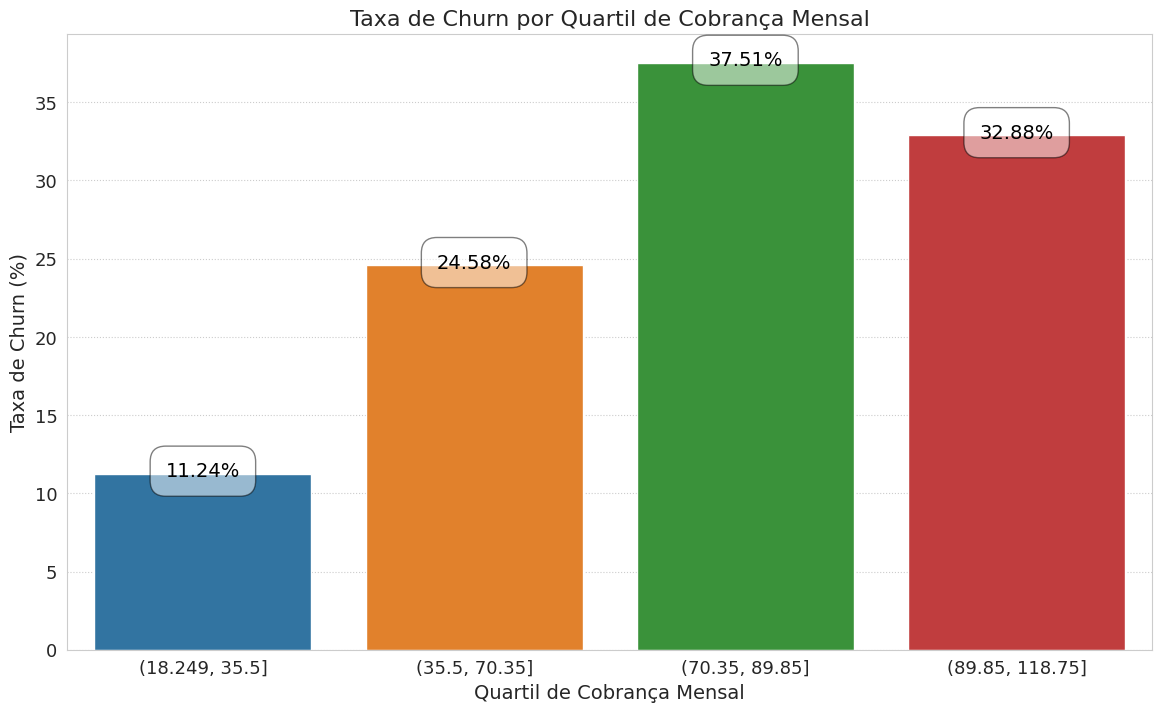

In [185]:
telecom_copy['quartis_monthly_charges'] = pd.qcut(telecom_copy['monthly_charges'], 4)
taxa_churn_quartil = telecom_copy.groupby('quartis_monthly_charges')['end_date_class'].mean() * 100

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x=taxa_churn_quartil.index, y=taxa_churn_quartil, ax=ax)
ax.set_xlabel('Quartil de Cobrança Mensal', fontsize=14)
ax.set_ylabel('Taxa de Churn (%)', fontsize=14)
ax.set_title('Taxa de Churn por Quartil de Cobrança Mensal', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(rotation=0)  
for p, percentage in zip(ax.patches, taxa_churn_quartil):
    height = p.get_height()
    if height > 0:  # Exclude bars with height 0
        ax.annotate(f'{percentage:.2f}%',
                    xytext=(0, 2),
                    textcoords='offset points',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    ha='center',
                    va='center',
                    color='black',
                    fontsize=14,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8', alpha=0.5))

plt.show()

* A taxa de churn tem tendencia crescente a medida que aumenta o quartil de cobrança mensal. Isso indica que os clientes com cobranças mensais mais altas têm maior probabilidade de cancelar seus contratos em comparação com os clientes com cobranças mensais mais baixas.

* A taxa de churn é consideravelmente menor no primeiro quartil (18,25 a 35,5), ou seja, cobranças mensais nessa faixa tendem a reter mais os clientes do que em faixas de cobrança mensal mais altas.

* A taxa de churn é maior no quartil 3 que é moderadamente mais altos (70,35 a 89,85). Esses clientes podem ter expectativas muito altas devido aos valores mais altos que estão pagando ou mesmo podem ser mais propensos a cancelar o contrato atual por alternativas mais baratas. Além disso, esses clientes podem enfretar problemas contínuos que levam à insatisfação e, consequentemente, ao desejo de cancelar o contrato.

In [186]:
quartis_mapping = {
    telecom_copy['quartis_monthly_charges'].unique()[0]: 1,
    telecom_copy['quartis_monthly_charges'].unique()[1]: 2,
    telecom_copy['quartis_monthly_charges'].unique()[2]: 3,
    telecom_copy['quartis_monthly_charges'].unique()[3]: 4
}
telecom_copy['category_monthly_charges'] = telecom_copy['quartis_monthly_charges'].map(quartis_mapping).astype('int')

In [187]:
df_quartil = telecom_copy[telecom_copy['category_monthly_charges'] == 4]

In [188]:
telecom_copy.groupby(['category_monthly_charges', 'end_date_class'])[cat_num].mean()

monthly_charges  total_charges  \
category_monthly_charges end_date_class                                   
1                        0                     21.991432     692.482385   
                         1                     24.117172     209.347980   
2                        0                     55.891742    1781.565653   
                         1                     55.230991     642.950346   
3                        0                     80.388616    3157.110428   
                         1                     80.245296    1141.351973   
4                        0                    101.590381    5314.107331   
                         1                     99.487457    3097.378201   

                                         contract_time  
category_monthly_charges end_date_class                 
1                        0                   31.578623  
                         1                    8.509764  
2                        0                   31.910736  
                         1                   11.816513  
3                        0                   39.640225  
                         1                   14.273141  
4                        0                   52.508446  
                         1                   30.935525

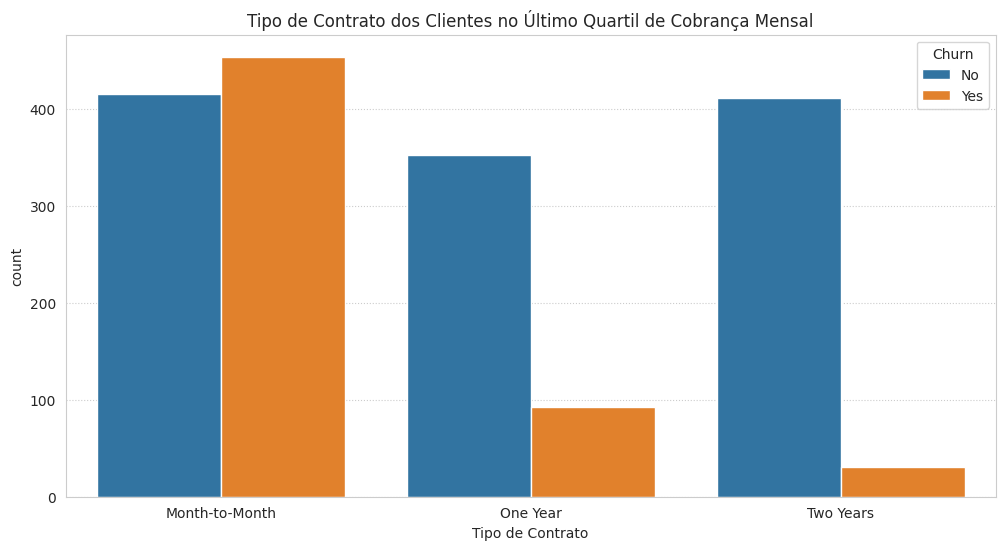

In [189]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df_quartil, x='type', hue='end_date_class', ax=ax)
plt.title('Tipo de Contrato dos Clientes no Último Quartil de Cobrança Mensal')
plt.xlabel('Tipo de Contrato')
plt.xticks(ticks=[0, 1, 2], labels=['Month-to-Month', 'One Year', 'Two Years'])
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

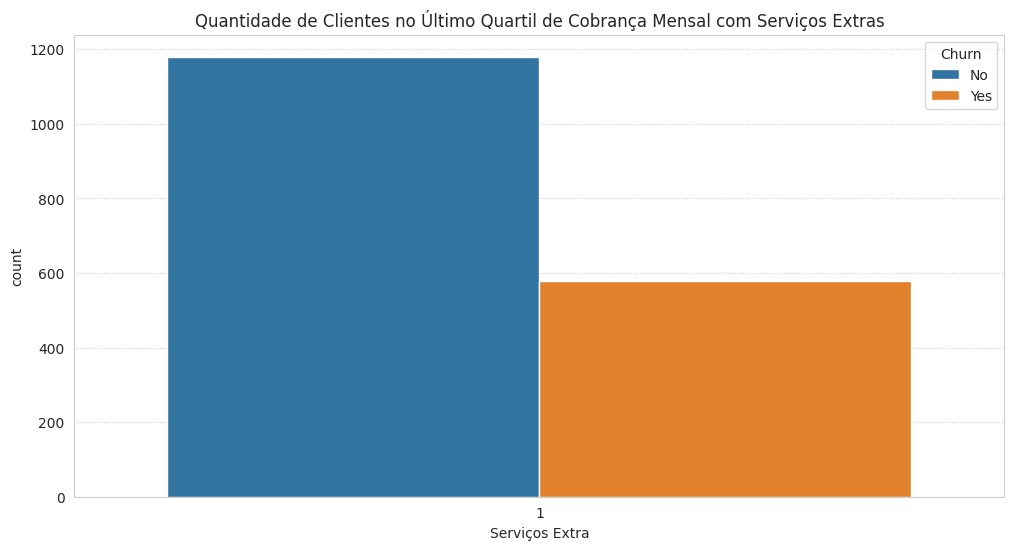

In [190]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(df_quartil, x='has_additional_services', hue='end_date_class', ax=ax)
plt.title('Quantidade de Clientes no Último Quartil de Cobrança Mensal com Serviços Extras')
plt.xlabel('Serviços Extra')
plt.legend(title='Churn', labels=['No', 'Yes'])

plt.show()

In [191]:
service_counts = df_quartil.groupby(['end_date_class'])[additional_services].sum()
service_counts

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
end_date_class,,,,,,
0,561,790,817,613,991,1005
1,133,270,313,153,529,517


<Figure size 1200x600 with 0 Axes>

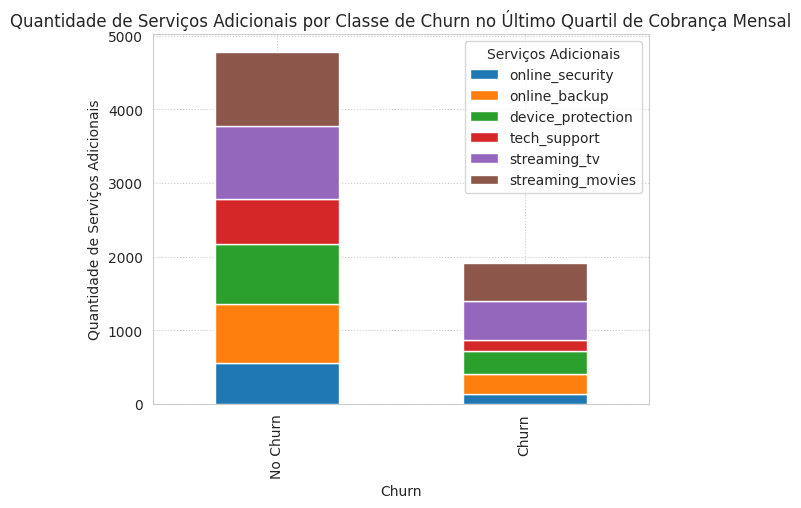

In [192]:
service_counts = df_quartil.groupby(['end_date_class'])[additional_services].sum()

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
service_counts.plot(kind='bar', stacked=True)
plt.title('Quantidade de Serviços Adicionais por Classe de Churn no Último Quartil de Cobrança Mensal')
plt.xlabel('Churn')
plt.ylabel('Quantidade de Serviços Adicionais')
plt.legend(title='Serviços Adicionais', labels=additional_services)
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.show()

* Sobre os clientes que compõem o último quartil de cobrança mensal(89.85, 118.75]:

    * Os clientes com contrato ativo têm contratos mais longos em comparação com aos clientes de mesmo grupo no terceiro quartil. 

    * A oferta de contratos de dois anos é mais comum entre os clientes. 

    * Todos os clientes possuem serviços adicionais contratados, sendo os principais tipos de serviços de streaming e proteção de dispositivos. 

* Com base nisso, é provavel que o tempo de contrato mais longo  e a disponibilidade de serviços adicionais podem ser fatores importantes para reduzir a taxa de churn.

In [193]:
# Coluna "cohort" com base na coluna "begin_date"
telecom_copy['cohort'] = telecom_copy['begin_date'].dt.to_period('M')
telecom_copy['cohort'] = telecom_copy['cohort'].dt.strftime('%Y-%m')

# Coluna "period" com base na coluna "begin_date"
telecom_copy['period'] = (telecom_copy['begin_date'] - telecom_copy['begin_date'].min()) / np.timedelta64(1, 'M')
telecom_copy['period'] = telecom_copy['period'].round().astype(int)

# Número total de clientes na coorte
cohort_counts = telecom_copy.groupby('cohort')['customer_id'].nunique().reset_index()
cohort_counts.rename(columns={'customer_id': 'total_customers'}, inplace=True)

# Número de clientes churn na coorte
churned_customers = telecom_copy[telecom_copy['end_date_class'] == 1].groupby('cohort')['customer_id'].nunique().reset_index()
churned_customers.rename(columns={'customer_id': 'churned_customers'}, inplace=True)

# Combinando os dataframes calculados com o dataframe original usando 'cohort' como chave
telecom_copy = pd.merge(telecom_copy, cohort_counts, on='cohort', how='left')
telecom_copy = pd.merge(telecom_copy, churned_customers, on='cohort', how='left')

# Taxa de churn por coorte
telecom_copy['churn_rate'] = telecom_copy['churned_customers'] / telecom_copy['total_customers']


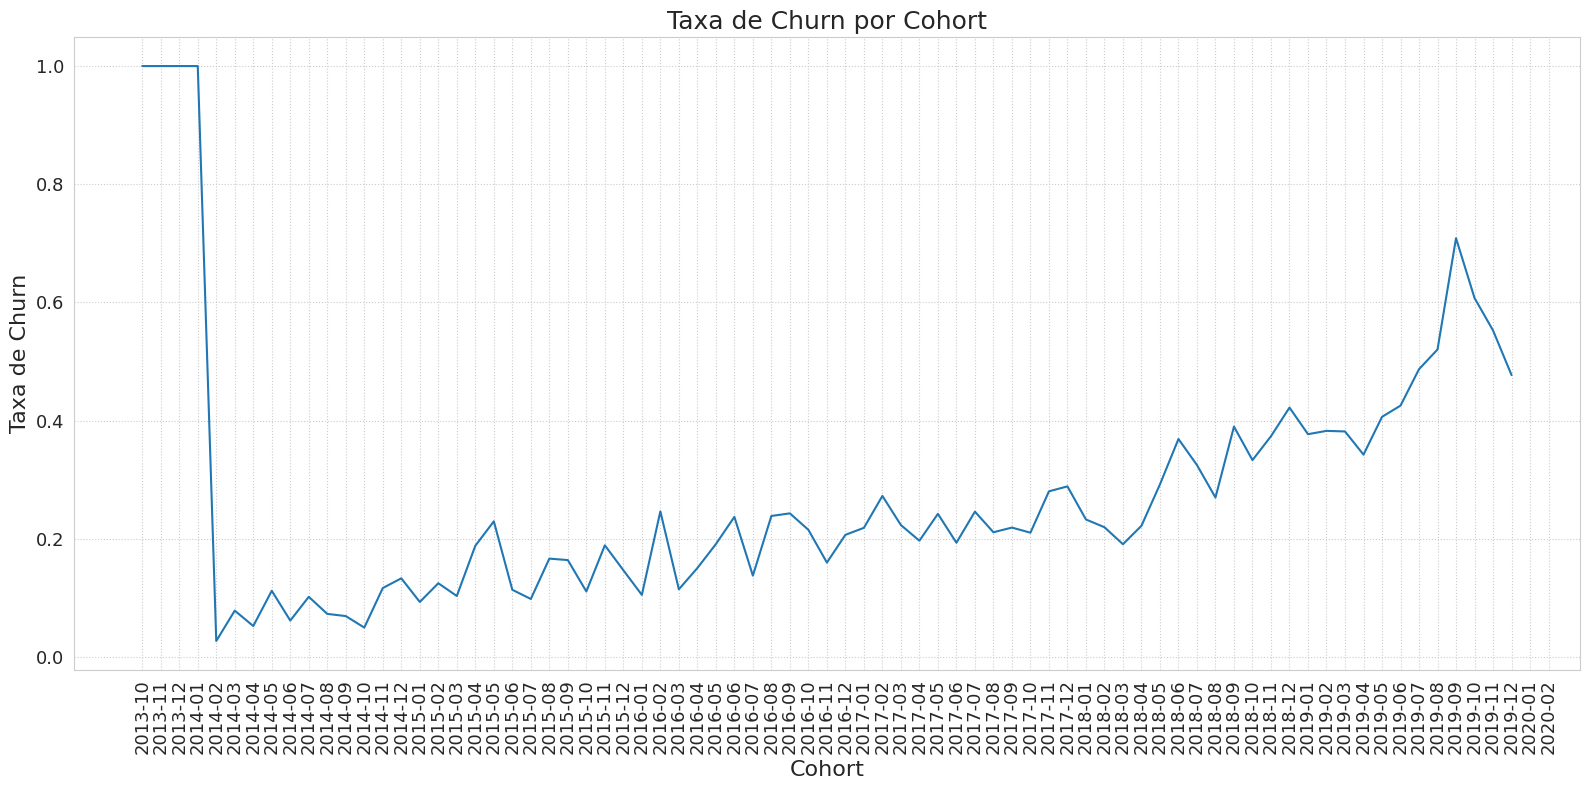

In [194]:
pivot_data = telecom_copy.groupby('cohort')['churn_rate'].mean()

fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=pivot_data.index, y=pivot_data.values, ax=ax)

plt.xlabel('Cohort', fontsize=16)
plt.ylabel('Taxa de Churn', fontsize=16)
plt.title('Taxa de Churn por Cohort', fontsize=18)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()


* Aparentemente parece haver um padrão de redução da taxa de churn nos primeiros meses de cada cohort seguida e um aumento nos últimos meses.

* No início do contrato, os clientes podem estar mais envolvidos e satisfeitos com os serviços, o que resulta em uma taxa de churn inicialmente baixa. No entanto, à medida que o tempo passa, podem surgir diferentes motivos que levam os clientes a considerar o cancelamento de seus contratos:
    * Insatisfação contínua com a qualidade dos serviços.

    * Problemas recorrentes de conexão

    * Falta de recursos ou benefícios adicionais

    * Aumento dos preços

    * Falta de suporte adequado ao cliente

    * Disponibilidade de ofertas mais atraentes de outras empresas de telecomunicações.

In [195]:
telecom_copy['churned_customers'].fillna(0, inplace=True)
telecom_copy['churn_rate'].fillna(0, inplace=True)

In [196]:
telecom_copy.internet_service.value_counts()

1    3096
0    2421
2    1526
Name: internet_service, dtype: int64

In [197]:
telecom_copy.drop(['customer_id', 'gender', 'end_date', 'cohort', 'begin_date', 'quartis_monthly_charges', 'churned_customers', 'total_customers'], axis=1, inplace=True)

## Modelagem

In [198]:

X = telecom_copy.drop('end_date_class', axis=1)
y = telecom_copy['end_date_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = [
    ('DecisionTreeClassifier', DecisionTreeClassifier(), {'classifier__max_depth': [1, 8, 16]}),
    ('RandomForestClassifier', RandomForestClassifier(), {'classifier__n_estimators': [10, 20, 60], 'classifier__max_depth': [1, 10]}),
    ('XGBClassifier', xgb.XGBClassifier(), {'classifier__learning_rate': [0.1, 0.01, 1], 'classifier__max_depth': [2, 9, 10], 'classifier__n_estimators': [5, 10, 20]}),
    ('CatBoostClassifier', CatBoostClassifier(verbose=0), {'classifier__learning_rate': [0.1, 0.01, 1], 'classifier__depth': [5, 7, 9], 'classifier__n_estimators': [10, 30]}),
    ('LogisticRegression', LogisticRegression(), {'classifier__C': [0.1, 0.01, 1], 'classifier__solver': ['liblinear', 'lbfgs', 'saga']})
]

# Definir o número de iterações do bootstrap
n_iterations = 20

# Listas para armazenar os resultados das métricas e os melhores parâmetros de cada modelo
model_names = []
accuracies = []
f1_scores = []
auc_rocs = []
best_params_list = []

# Loop através dos modelos e realizar o bootstrap
for model_name, model, param_grid in models:
    accuracy_list = []
    f1_score_list = []
    auc_roc_list = []

    for _ in tqdm(range(n_iterations), desc=f'Evaluating {model_name}'):
            # Bootstrap amostragem dos dados de treino e teste
            indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
            X_train_bootstrapped = X_train.iloc[indices]
            y_train_bootstrapped = y_train.iloc[indices]

            # Criar um pipeline de pré-processamento e modelo
            preprocessor = ColumnTransformer(transformers=[('numerical', StandardScaler(), cat_num)])
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  # Padronização dos dados numéricos
                ('smote', SMOTE(random_state=42)),  # Balanceamento das classes usando SMOTE
                ('classifier', model)  # Modelo atual
            ])

            # Usar RandomizedSearchCV para encontrar os melhores hiperparâmetros
            random_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
            random_search.fit(X_train_bootstrapped, y_train_bootstrapped)

            # Obter o melhor modelo e seus hiperparâmetros
            best_model = random_search.best_estimator_

            # Prever rótulos do conjunto de teste
            y_pred = best_model.predict(X_test)

            # Calcular métricas de desempenho
            accuracy_list.append(accuracy_score(y_test, y_pred))
            f1_score_list.append(f1_score(y_test, y_pred))
            auc_roc_list.append(roc_auc_score(y_test, y_pred))

    # Calcular as médias das métricas para o modelo atual
    mean_accuracy = round(np.mean(accuracy_list), 2)
    sd_accuracy = round(np.std(accuracy_list), 2)
    mean_f1_score = round(np.mean(f1_score_list), 2)
    sd_f1_score = round(np.std(f1_score_list), 2)
    mean_auc_roc = round(np.mean(auc_roc_list), 2)
    sd_auc_roc = round(np.std(auc_roc_list), 2)

        # Armazenar os resultados na lista
    model_names.append(model_name)
    accuracies.append((mean_accuracy, sd_accuracy))
    f1_scores.append((mean_f1_score, sd_f1_score))
    auc_rocs.append((mean_auc_roc, sd_auc_roc))
        
    # Armazenar os melhores parâmetros do modelo atual
    best_params_list.append(random_search.best_params_)

# Criar um DataFrame para exibir os resultados
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy ± sd': accuracies,
    'F1 Score ± sd': f1_scores,
    'AUC ROC ± sd': auc_rocs
})


# Loop para imprimir os modelos com seus melhores hiperparâmetros
for model_name, best_params in zip(model_names, best_params_list):
    print(f"Model: {model_name}")
    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print()

# Exibir a tabela com os resultados
results_df

Evaluating LogisticRegression: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Model: DecisionTreeClassifier
Best Parameters:
classifier__max_depth: 16

Model: RandomForestClassifier
Best Parameters:
classifier__max_depth: 10
classifier__n_estimators: 20

Model: XGBClassifier
Best Parameters:
classifier__learning_rate: 1
classifier__max_depth: 10
classifier__n_estimators: 20

Model: CatBoostClassifier
Best Parameters:
classifier__depth: 9
classifier__learning_rate: 1
classifier__n_estimators: 30

Model: LogisticRegression
Best Parameters:
classifier__C: 0.01
classifier__solver: lbfgs



,Model,Accuracy ± sd,F1 Score ± sd,AUC ROC ± sd
0,DecisionTreeClassifier,"(0.78, 0.01)","(0.62, 0.02)","(0.75, 0.01)"
1,RandomForestClassifier,"(0.79, 0.01)","(0.65, 0.01)","(0.77, 0.01)"
2,XGBClassifier,"(0.84, 0.01)","(0.71, 0.02)","(0.8, 0.01)"
3,CatBoostClassifier,"(0.83, 0.01)","(0.7, 0.02)","(0.8, 0.01)"
4,LogisticRegression,"(0.75, 0.01)","(0.62, 0.0)","(0.75, 0.0)"


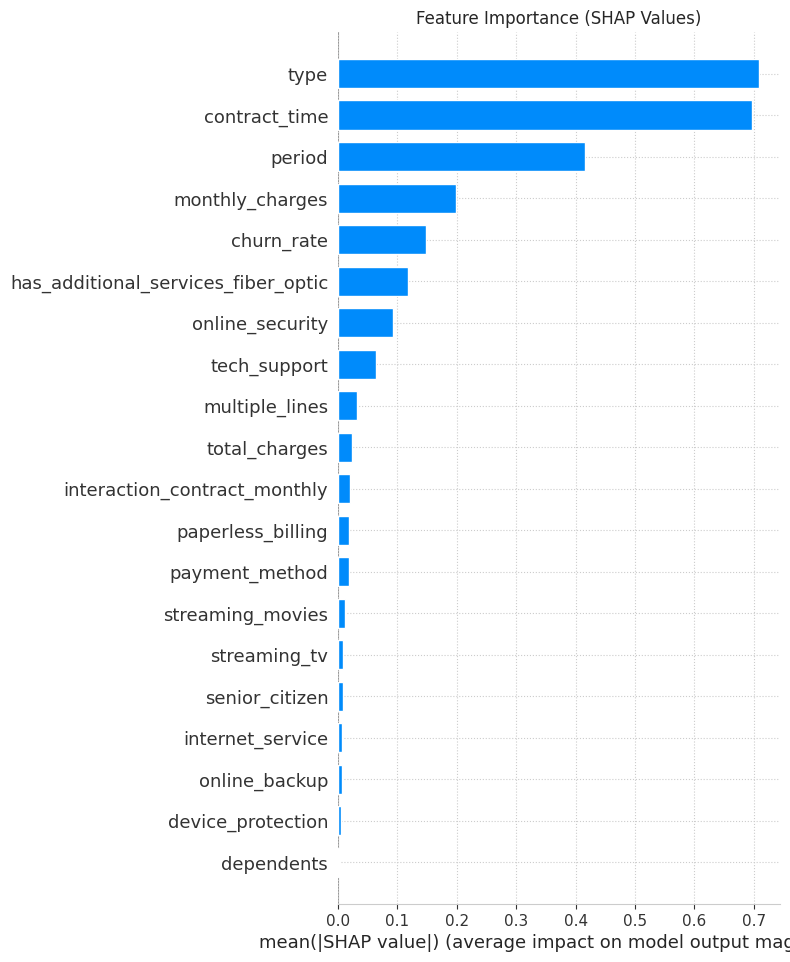

In [199]:
# Treinar o XGBClassifier no conjunto de treinamento completo
best_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=20)  # Defina os hiperparâmetros com base na tabela de resultados
best_model.fit(X_train, y_train)

# Criar um shap.Explainer para modelos em arvore para o modelo treinado
explainer = shap.TreeExplainer(best_model)

# Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Visualizar a importância das features usando o SHAP
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

# Exibir o plot
plt.title('Feature Importance (SHAP Values)')
plt.show()


In [200]:
# Prever os rótulos do conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular os erros do modelo
errors = y_pred != y_test

# Adicionar a coluna de erros ao DataFrame de teste
df_test = X_test.copy()
df_test['erro'] = errors

# Calcular a média do erro por segmento (se houver uma coluna 'segmento' no DataFrame)
mean_error_by_segment = df_test.groupby('cluster_labels')['erro'].mean()

# Exibir a média do erro por segmento
print(mean_error_by_segment)

cluster_labels
0    0.040332
1    0.086614
2    0.137821
Name: erro, dtype: float64


In [201]:
# Prever as probabilidades de previsão do modelo
y_probs = best_model.predict_proba(X_test)[:, 1]
df_test['prob'] = y_probs


mean_prob = df_test['prob'].mean()
mean_prob_cluster = df_test.groupby('cluster_labels')['prob'].mean()

print(f'Probabilidade média do modelo por cluster: {mean_prob_cluster}')


Probabilidade média do modelo por cluster: cluster_labels
0    0.345157
1    0.181925
2    0.257927
Name: prob, dtype: float32


* Considerando as métricas de avaliação, o modelo XGBClassifier com os seguintes hiperparâmetros ('learning_rate': 1, 'max_depth': 10, 'n_estimators': 20) apresenta um desempenho geral superior aos demais modelos. Ele possui alta acurácia (Accuracy = 0,85) um bom equilíbrio entre sensibilidade e precisão (F1-Score = 0,71) e uma alta capacidade de distinguir corretamente entre as classes positivas e negativas (AUC-ROC = 0,80).

* Ao analisar a importância das características (features), podemos observar que as variáveis de tipo de contrado (type) e tempo de contrato (contract_time) são as mais. As variáveis de período do coorte(period), cobrança mensal (monthly_charges), taxa de churn (churn_rate), assinatura de serviços adicionais para clientes com serviço de internet do tipo fibra ótica (has_additional_services_fiber_optic), contrato de segurança online (online_security) e suporte técnico (tech_support) também têm um impacto significativo nas previsões.

## Conclusões

* Em resumo:

    * Clientes com contrato ativo têm contratos mais longos em comparação com os clientes churn, indicando que contratos de longo prazo podem contribuir para a retenção dos clientes.

    * É interessante notar que a maioria dos clientes com contrato ativo possui contratos de 2 anos, o que pode ser uma estratégia a ser incentivada para reduzir a taxa de churn.

    * Todos os clientes têm serviços adicionais contratados, sendo os principais tipos de serviços de streaming e proteção de dispositivos. Oferecer esses serviços adicionais pode ser uma maneira eficaz de aumentar a satisfação dos clientes e reduzir a taxa de churn.

    * É importante notar que a taxa de churn é consideravelmente menor no primeiro quartil de cobrança mensal e maior no terceiro quartil. Isso indica que os clientes com cobranças mensais mais baixas tendem a ter uma maior retenção, enquanto os clientes com cobranças mensais mais altas têm maior probabilidade de cancelar seus contratos. Já Os clientes do último quartil de cobrança mensal têm contratos mais longos e também possuem serviços adicionais contratados. Essa combinação pode estar relacionada à menor taxa de churn nesse grupo apesar da cobrança mensal mais alta.

    * O modelo XGBClassifier apresentou o melhor desempenho entre os modelos avaliados para prever o churn dos clientes. Isso sugere que o modelo pode ser uma ferramenta útil para a empresa identificar clientes em risco de churn e implementar estratégias de retenção direcionadas.